# Estimate K corrections and absolute magnitudes using AstroCLIP

In this notebook we will calculate galaxy K corrections using AstroCLIP model. 

* This is a regression task, the target predictions are Real numbers.
* The input of AstroCLIP can be either an image or a spectra, because it's a multimodal model.
* The most challenging task is to predict K corrections from images, so we will focus on the task of predicting K correction from images.

The embeddings calculated using the trained AstroCLIP models have already been stored in dataset `kcorr_ds`.

This script will process the results of zero-shot and few-shot models trained on top of these embeddings.

## Load the dataset

In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from models.plotting import plot_scatter

In [19]:
import numpy as np
import torch
from astropy.table import Table, join
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from utils.data_utils import prepare_dataset, prepare_dataset_for_visualization
import seaborn as sns

In [3]:
TRAIN_DS_PATH = "../data/train_df_kcorr_panda.h5"
TEST_DS_PATH =  "../data/test_df_kcorr_panda.h5"

train_df = pd.read_hdf(TRAIN_DS_PATH, key='data')
test_df = pd.read_hdf(TEST_DS_PATH, key='data')

# Analysis of zero shot predictions
Let's define scaffolding to process the zero shot predictions

In [4]:
# These predictions are calculated by running kcorrection/calculate_astroclip_k_corrections_zero_shot.py
ZERO_SHOT_PREDICTIONS = "../data/astroclip_predictions_zero_shot.pkl"

In [5]:
with open(ZERO_SHOT_PREDICTIONS, "rb") as f:
    zero_shot_predictions = pickle.load(f) 

In [6]:
from sklearn.metrics import mean_absolute_error, r2_score

In [7]:
def display_zero_shot_results(model_result):
    predictions = []
    for (k, target), metrics in model_result.items():
        predictions.append([k, target, metrics['mae'], metrics['r2']])
    
    df = pd.DataFrame(predictions, columns=['K', 'Target', 'MAE', 'R²'])
    
    # Plot results
    plt.figure(figsize=(12, 6))
    
    for target in df['Target'].unique():
        subset = df[df['Target'] == target]
        plt.plot(subset['K'], subset['MAE'], marker='o', linestyle='-', label=f"{target} (MAE)")
    
    plt.xlabel('K (Number of Neighbors)')
    plt.ylabel('Metric Value')
    plt.title('MAE Across Different K Values')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.show()
    
    
    plt.figure(figsize=(12, 6))
    
    for target in df['Target'].unique():
        subset = df[df['Target'] == target]
        plt.plot(subset['K'], subset['R²'], marker='s', linestyle='--', label=f"{target} (R²)")
    
    plt.xlabel('K (Number of Neighbors)')
    plt.ylabel('Metric Value')
    plt.title('R² Across Different K Values')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.show()
    
    # Compute best values and corresponding K
    best_mae = df.loc[df.groupby('Target')['MAE'].idxmin()]
    best_r2 = df.loc[df.groupby('Target')['R²'].idxmax()]
    
    
    best_values = pd.DataFrame({
        'Target': best_mae['Target'].unique(),
        'Best MAE': best_mae['MAE'].values,
        'Best K (MAE)': best_mae['K'].values,
        'Best R²': best_r2['R²'].values,
        'Best K (R²)': best_r2['K'].values
    })
    
    
    # Display the nicely formatted table
    display(df.pivot(index="K", columns="Target", values=["MAE", "R²"]).round(4))
    
    # Display best values table
    display(best_values.round(4))

## Zero shot results, training a single model to learn band jumps

In this scenario, a single model is fit to predict the target variable. In the following section we will inspect the results obtained training several models for each target variable, each sub-model tailored to one specfic pair of input-output bands.

Therefore, the results in this sub section tackle a harder task, since the model is expected to learn about optimal band jumps.


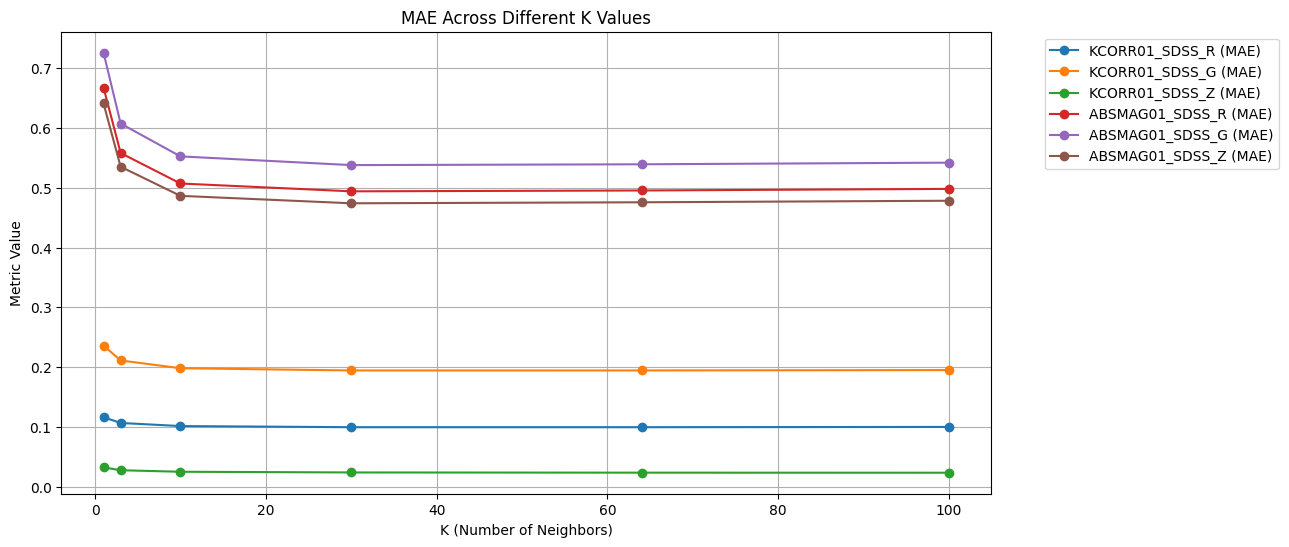

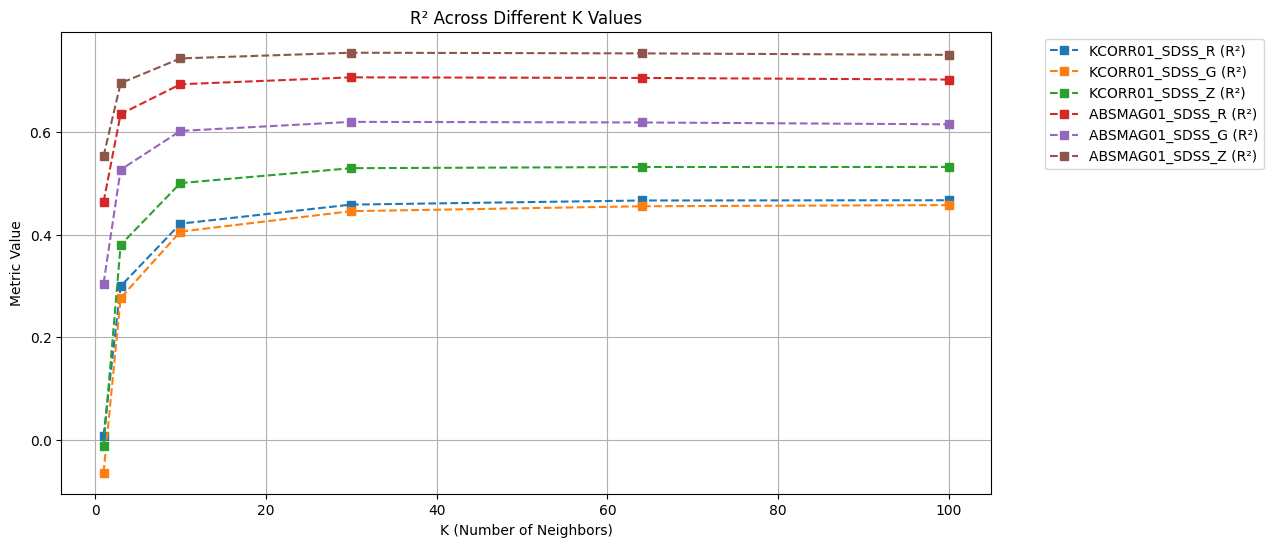

MAE                                                 \
Target ABSMAG01_SDSS_G ABSMAG01_SDSS_R ABSMAG01_SDSS_Z KCORR01_SDSS_G   
K                                                                       
1               0.7259          0.6676          0.6410         0.2361   
3               0.6074          0.5582          0.5352         0.2112   
10              0.5525          0.5071          0.4865         0.1982   
30              0.5379          0.4940          0.4740         0.1944   
64              0.5393          0.4955          0.4757         0.1944   
100             0.5420          0.4981          0.4783         0.1951   

                                                  R²                  \
Target KCORR01_SDSS_R KCORR01_SDSS_Z ABSMAG01_SDSS_G ABSMAG01_SDSS_R   
K                                                                      
1              0.1162         0.0323          0.3044          0.4638   
3              0.1066         0.0275          0.5266          0.6351   
10             0.1014         0.0250          0.6023          0.6934   
30             0.0995         0.0238          0.6200          0.7069   
64             0.0995         0.0235          0.6188          0.7057   
100            0.1000         0.0234          0.6152          0.7026   

                                                                     
Target ABSMAG01_SDSS_Z KCORR01_SDSS_G KCORR01_SDSS_R KCORR01_SDSS_Z  
K                                                                    
1               0.5531        -0.0648         0.0077        -0.0124  
3               0.6955         0.2762         0.2993         0.3799  
10              0.7438         0.4058         0.4213         0.5005  
30              0.7549         0.4457         0.4585         0.5296  
64              0.7536         0.4553         0.4665         0.5319  
100             0.7508         0.4576         0.4670         0.5320

Target  Best MAE  Best K (MAE)  Best R²  Best K (R²)
0  ABSMAG01_SDSS_G    0.5379            30   0.6200           30
1  ABSMAG01_SDSS_R    0.4940            30   0.7069           30
2  ABSMAG01_SDSS_Z    0.4740            30   0.7549           30
3   KCORR01_SDSS_G    0.1944            30   0.4576          100
4   KCORR01_SDSS_R    0.0995            30   0.4670          100
5   KCORR01_SDSS_Z    0.0234           100   0.5320          100

In [8]:
display_zero_shot_results(zero_shot_predictions[0])

In [9]:
def normalized_mae(target, pred):
    """Compute normalized MAE (nMAE) using standard deviation of target."""
    mae = mean_absolute_error(target, pred)
    std_target = np.std(target)
    return mae / std_target if std_target != 0 else np.nan  # Avoid division by zero

def relative_r2(target, pred):
    """Compute relative R², normalizing by the variance of the target."""
    r2 = r2_score(target, pred)
    var_target = np.var(target)
    return r2 / var_target if var_target != 0 else np.n
    
print("Calculating normalized MAE for optimal predictors...")
for target_v, optk in [ ("KCORR01_SDSS_G",30), ("KCORR01_SDSS_R",30), ("KCORR01_SDSS_Z",100), \
                       ("ABSMAG01_SDSS_G",30), ("ABSMAG01_SDSS_R",30), ("ABSMAG01_SDSS_Z",30)]:
    redshift_range = (0,2)
    _, _, _, target = prepare_dataset(train_df, test_df, redshift_range[0], redshift_range[1], target_v)
    pred = zero_shot_predictions[0][(optk,target_v)]['preds']
    print(normalized_mae(target, pred))

Calculating normalized MAE for optimal predictors...
0.4678046669852448
0.39457448323523786
0.2836899333900077
0.4060973450678154
0.3535999021215741
0.32174412761902726


## Zero shot results, training a single model for each band of pairs

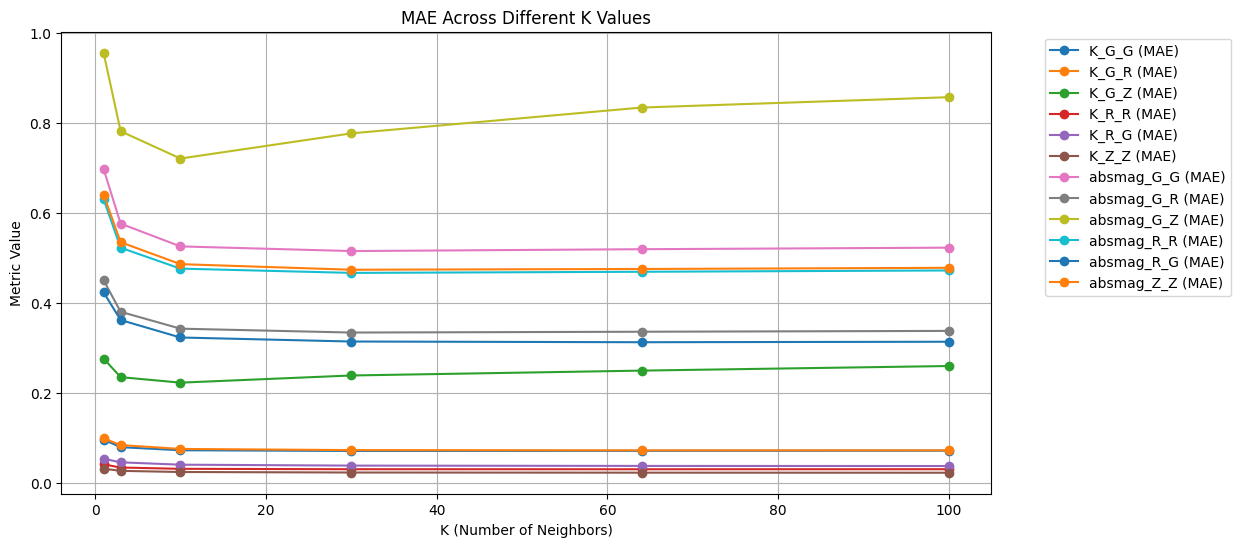

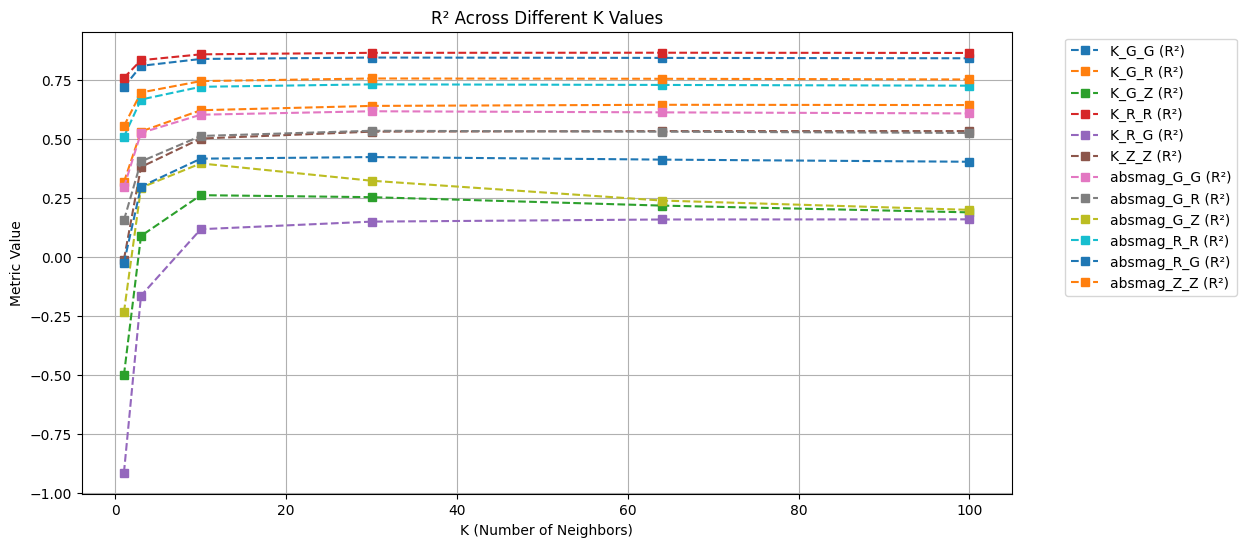

MAE                                                                \
Target   K_G_G   K_G_R   K_G_Z   K_R_G   K_R_R   K_Z_Z absmag_G_G absmag_G_R   
K                                                                              
1       0.0969  0.0998  0.2769  0.0544  0.0419  0.0323     0.6980     0.4508   
3       0.0801  0.0847  0.2356  0.0465  0.0349  0.0275     0.5764     0.3807   
10      0.0733  0.0762  0.2234  0.0412  0.0320  0.0250     0.5259     0.3432   
30      0.0717  0.0736  0.2393  0.0392  0.0311  0.0238     0.5155     0.3346   
64      0.0720  0.0731  0.2501  0.0385  0.0311  0.0235     0.5196     0.3364   
100     0.0724  0.0730  0.2603  0.0382  0.0312  0.0234     0.5231     0.3382   

                              ...      R²                                     \
Target absmag_G_Z absmag_R_G  ...   K_G_Z   K_R_G   K_R_R   K_Z_Z absmag_G_G   
K                             ...                                              
1          0.9559     0.4241  ... -0.5024 -0.9159  0.7576 -0.0124     0.2940   
3          0.7816     0.3624  ...  0.0875 -0.1659  0.8323  0.3799     0.5243   
10         0.7209     0.3236  ...  0.2604  0.1161  0.8572  0.5005     0.6014   
30         0.7768     0.3147  ...  0.2519  0.1483  0.8637  0.5296     0.6160   
64         0.8341     0.3131  ...  0.2162  0.1573  0.8641  0.5319     0.6113   
100        0.8572     0.3142  ...  0.1875  0.1580  0.8631  0.5320     0.6068   

                                                               
Target absmag_G_R absmag_G_Z absmag_R_G absmag_R_R absmag_Z_Z  
K                                                              
1          0.1542    -0.2359    -0.0275     0.5082     0.5531  
3          0.4031     0.2923     0.2966     0.6657     0.6955  
10         0.5113     0.3949     0.4151     0.7197     0.7438  
30         0.5333     0.3216     0.4219     0.7300     0.7549  
64         0.5295     0.2376     0.4111     0.7276     0.7536  
100        0.5241     0.1981     0.4020     0.7244     0.7508  

[6 rows x 24 columns]

Target  Best MAE  Best K (MAE)  Best R²  Best K (R²)
0        K_G_G    0.0717            30   0.8436           30
1        K_G_R    0.0730           100   0.6434           64
2        K_G_Z    0.2234            10   0.2604           10
3        K_R_G    0.0382           100   0.1580          100
4        K_R_R    0.0311            64   0.8641           64
5        K_Z_Z    0.0234           100   0.5320          100
6   absmag_G_G    0.5155            30   0.6160           30
7   absmag_G_R    0.3346            30   0.5333           30
8   absmag_G_Z    0.7209            10   0.3949           10
9   absmag_R_G    0.3131            64   0.4219           30
10  absmag_R_R    0.4670            30   0.7300           30
11  absmag_Z_Z    0.4740            30   0.7549           30

In [10]:
display_zero_shot_results(zero_shot_predictions[1])

In [27]:
# Let's reassemble the piece-wise defined predictors as one
results = []

_, _, _, y_krr, _, z_rr = prepare_dataset_for_visualization(train_df, test_df, 0, 0.3885, "KCORR01_SDSS_R")
_, _, _, y_krg, _, z_rg = prepare_dataset_for_visualization(train_df, test_df, 0.3885, 2, "KCORR01_SDSS_R")

threshold_g1 = 0.3031
threshold_g2 = 0.814

_, _, _, y_kgg, _, z_gg = prepare_dataset_for_visualization(train_df, test_df, 0, threshold_g1, "KCORR01_SDSS_G")
_, _, _, y_kgr, _, z_gr = prepare_dataset_for_visualization(train_df, test_df, threshold_g1, threshold_g2, "KCORR01_SDSS_G")
_, _, _, y_kgz, _, z_gz = prepare_dataset_for_visualization(train_df, test_df, threshold_g2, 2, "KCORR01_SDSS_G")
gt_r = np.hstack((y_krr, y_krg))
gt_g = np.hstack((y_kgg, y_kgr, y_kgz))
gt_z_r = np.hstack((z_rr, z_rg))
gt_z_g = np.hstack((z_gg, z_gr, z_gz))

_, _, _, y_arr = prepare_dataset(train_df, test_df, 0, 0.3885, "ABSMAG01_SDSS_R")
_, _, _, y_arg = prepare_dataset(train_df, test_df, 0.3885, 2, "ABSMAG01_SDSS_R")

_, _, _, y_agg = prepare_dataset(train_df, test_df, 0, threshold_g1, "ABSMAG01_SDSS_G")
_, _, _, y_agr = prepare_dataset(train_df, test_df, threshold_g1, threshold_g2, "ABSMAG01_SDSS_G")
_, _, _, y_agz = prepare_dataset(train_df, test_df, threshold_g2, 2, "ABSMAG01_SDSS_G")

gt_ar = np.hstack((y_arr, y_arg))
gt_ag = np.hstack((y_agg, y_agr, y_agz))


for k in [1,3,10,30,64,100]:
    preds_krr = zero_shot_predictions[1][(k,"K_R_R")]['preds']
    preds_krg = zero_shot_predictions[1][(k,"K_R_G")]['preds']

    pred = np.hstack((preds_krr, preds_krg))
    
    count = sum(~np.isnan(pred))
    mae = np.mean(np.abs(pred - gt_r))
    r2 = r2_score(gt_r, pred)
    mse = np.mean((pred - gt_r) ** 2)
    rmse = np.sqrt(mse)
    nmae = normalized_mae(gt_r,pred)
    
    results.append({"k":k, "pred":pred, "gt": gt_r, "target": "KCORR01_SDSS_R" ,"MAE": mae, "R²": r2, "RMSE": rmse, "Count": count, "nmae": nmae})
    
    
    preds_kgg = zero_shot_predictions[1][(k,"K_G_G")]['preds']
    preds_kgr = zero_shot_predictions[1][(k,"K_G_R")]['preds']
    preds_kgz = zero_shot_predictions[1][(k,"K_G_Z")]['preds']
    
    pred = np.hstack((preds_kgg, preds_kgr, preds_kgz))
    
    count = sum(~np.isnan(pred))
    mae = np.mean(np.abs(pred - gt_g))
    r2 = r2_score(gt_g, pred)
    mse = np.mean((pred - gt_g) ** 2)
    rmse = np.sqrt(mse)
    nmae = normalized_mae(gt_g,pred)

    results.append({"k": k, "pred":pred, "gt": gt_g, "target": "KCORR01_SDSS_G","MAE": mae, "R²": r2, "RMSE": rmse, "Count": count, "nmae": nmae})

    preds_arr = zero_shot_predictions[1][(k,"absmag_R_R")]['preds']
    preds_arg = zero_shot_predictions[1][(k,"absmag_R_G")]['preds']

    pred = np.hstack((preds_arr, preds_arg))
    
    count = sum(~np.isnan(pred))
    mae = np.mean(np.abs(pred - gt_ar))
    r2 = r2_score(gt_ar, pred)
    mse = np.mean((pred - gt_ar) ** 2)
    rmse = np.sqrt(mse)
    nmae = normalized_mae(gt_ar,pred)

    results.append({"k":k, "pred":pred, "gt": gt_ar, "target": "ABSMAG01_SDSS_R" ,"MAE": mae, "R²": r2, "RMSE": rmse, "Count": count, "nmae": nmae})
    
    preds_agg = zero_shot_predictions[1][(k,"absmag_G_G")]['preds']
    preds_agr = zero_shot_predictions[1][(k,"absmag_G_R")]['preds']
    preds_agz = zero_shot_predictions[1][(k,"absmag_G_Z")]['preds']

    pred = np.hstack((preds_agg, preds_agr,preds_agz))
    
    count = sum(~np.isnan(pred))
    mae = np.mean(np.abs(pred - gt_ag))
    r2 = r2_score(gt_ag, pred)
    mse = np.mean((pred - gt_ag) ** 2)
    rmse = np.sqrt(mse)
    nmae = normalized_mae(gt_ag,pred)
    
    
    results.append({"k":k, "pred":pred, "gt": gt_ag,  "target": "ABSMAG01_SDSS_G" ,"MAE": mae, "R²": r2, "RMSE": rmse, "Count": count, "nmae": nmae})
    

In [28]:
# Convert results list to DataFrame
df = pd.DataFrame(results)

# Compute best values
best_mae = df.loc[df.groupby('target')['MAE'].idxmin()]
best_r2 = df.loc[df.groupby('target')['R²'].idxmax()]
best_nmae = df.loc[df.groupby('target')['nmae'].idxmin()]


# Create a summary table
best_values = pd.DataFrame({
    'Target': best_mae['target'].tolist(),
    'Best MAE': best_mae['MAE'].tolist(),
    'Best K (MAE)': best_mae['k'].tolist(),
    'Best R²': best_r2['R²'].tolist(),
    'Best K (R²)': best_r2['k'].tolist(),
    'Best NMAE' : best_nmae['nmae'].tolist(),
    'Best K (NMAE)': best_nmae['k'].tolist()
})

# Display table of all results
display(df.pivot(index="k", columns="target", values=["MAE", "R²", "RMSE", "Count"]).round(4))

# Display the best values table
display(best_values.round(4))


MAE                                                \
target ABSMAG01_SDSS_G ABSMAG01_SDSS_R KCORR01_SDSS_G KCORR01_SDSS_R   
k                                                                      
1               0.6105          0.5920         0.0988         0.0443   
3               0.5072          0.4928         0.0825         0.0371   
10              0.4612          0.4478         0.0750         0.0337   
30              0.4518          0.4384         0.0732         0.0327   
64              0.4553          0.4401         0.0732         0.0324   
100             0.4583          0.4427         0.0735         0.0325   

                    R²                                                \
target ABSMAG01_SDSS_G ABSMAG01_SDSS_R KCORR01_SDSS_G KCORR01_SDSS_R   
k                                                                      
1               0.5674          0.6152         0.8848         0.9123   
3               0.7066          0.7382         0.9216         0.9430   
10              0.7551          0.7807         0.9349         0.9539   
30              0.7641          0.7881         0.9375         0.9558   
64              0.7612          0.7859         0.9374         0.9561   
100             0.7583          0.7833         0.9369         0.9559   

                  RMSE                                                \
target ABSMAG01_SDSS_G ABSMAG01_SDSS_R KCORR01_SDSS_G KCORR01_SDSS_R   
k                                                                      
1               0.8712          0.8667         0.1411         0.0747   
3               0.7175          0.7149         0.1164         0.0602   
10              0.6555          0.6543         0.1060         0.0541   
30              0.6433          0.6432         0.1039         0.0530   
64              0.6473          0.6465         0.1040         0.0528   
100             0.6512          0.6504         0.1044         0.0529   

                 Count                                                
target ABSMAG01_SDSS_G ABSMAG01_SDSS_R KCORR01_SDSS_G KCORR01_SDSS_R  
k                                                                     
1              41296.0         41296.0        41296.0        41296.0  
3              41296.0         41296.0        41296.0        41296.0  
10             41296.0         41296.0        41296.0        41296.0  
30             41296.0         41296.0        41296.0        41296.0  
64             41296.0         41296.0        41296.0        41296.0  
100            41296.0         41296.0        41296.0        41296.0

Target  Best MAE  Best K (MAE)  Best R²  Best K (R²)  Best NMAE  \
0  ABSMAG01_SDSS_G    0.4518            30   0.7641           30     0.3411   
1  ABSMAG01_SDSS_R    0.4384            30   0.7881           30     0.3138   
2   KCORR01_SDSS_G    0.0732            30   0.9375           30     0.1760   
3   KCORR01_SDSS_R    0.0324            64   0.9561           64     0.1287   

   Best K (NMAE)  
0             30  
1             30  
2             30  
3             64

## Summary of zero shot results

Models have been trained to predict six target variables (k corrections and absolute magnitudes in bands g, r and z).

Two different approaches were attempted:

- Single-model for all redshift range: Fit a single model for each target variable, the model is expected to learn band jumps.
- Split the redshift range by optimal input band, and fit a single model for each sub-region. This requires explicit knowldege of the redshift of the target galaxy.

For each approach, the paremeter K of K Neareast Neighbors was optimized.

The results are summarized below:





In [29]:
import pandas as pd

# TODO: Decide what's more important: MAE or R2. These columns may come from different K as of now.

# Define the data
data = {
    "Target Variable": [
        "KCORR01_SDSS_G", "KCORR01_SDSS_R", "KCORR01_SDSS_Z",
        "ABSMAG01_SDSS_G", "ABSMAG01_SDSS_R", "ABSMAG01_SDSS_Z"
    ],
    "Single model – MAE": [0.1944, 0.0995, 0.0234, 0.5379, 0.494, 0.474],
    "Multiple models – MAE": [0.0732, 0.0324, 0.0234, 0.4518, 0.4384, 0.474],
    "Single model – R²": [0.4576, 0.467, 0.532, 0.62, 0.7069, 0.7549],
    "Multiple models – R²": [0.9375, 0.9561, 0.532, 0.7641, 0.7881, 0.7549]
}

# Create a DataFrame
df_tmp = pd.DataFrame(data)

# Display the table
df_tmp.style.set_table_styles(
    [{'selector': 'th', 'props': [('font-size', '12pt'), ('text-align', 'center')]},
     {'selector': 'td', 'props': [('font-size', '12pt'), ('text-align', 'center')]}]
).set_properties(**{'text-align': 'center'})

The two metrics reported are useful to pick the best hyperparameter for each model, but may not be suitable to assert "we are much better at predicting K corrections in band G than we are at predicting absolute magnitudes in band G". 

Target variables have very different scales and variabilities. 
- K corrections in band Z have very little variance at this redshift, all of the values being almost zero.
- Absolute magnitudes are in a different scale than K corrections.

Thus, let's normalize the previous table to enable for inter-row comparisons.

In [30]:
# Define the data
data = {
    "Target Variable": [
        "KCORR01_SDSS_G", "KCORR01_SDSS_R", "KCORR01_SDSS_Z",
        "ABSMAG01_SDSS_G", "ABSMAG01_SDSS_R", "ABSMAG01_SDSS_Z"
    ],
    "Single model – Normalized MAE": [0.4678, 0.3945, 0.2836 , 0.4060, 0.3535, 0.3217],
    "Multiple models – Normalized MAE": [0.1760	, 0.1287, 0.2836, 0.3411, 0.3138	, 0.3217]
}

# Create a DataFrame
df_tmp = pd.DataFrame(data)

# Display the table
df_tmp.style.set_table_styles(
    [{'selector': 'th', 'props': [('font-size', '12pt'), ('text-align', 'center')]},
     {'selector': 'td', 'props': [('font-size', '12pt'), ('text-align', 'center')]}]
).set_properties(**{'text-align': 'center'})

Based on the previous table we can conclude:
- Our piece-wise defined models are much better at predicting the K corrections than the absolute magnitudes ; and excel at predicting K correction in bands G and R.
- The single-model predictors struggle to predict K corrections, likely due to the complexity introduced by band jumps and scarcity of data at higher redshifts. This approach is better at predicting absolute magnitudes than K corrections.
  

## Visualizations
This section provides several visualizations to understand the distribution of the target variable, the distribution of the predictions and the errors.

### Scatterplots
These plots are useful to inspect the distribution of the predicted variables as a function of redshift Z

In [31]:
def plot_scatterplot(target_v="KCORR01_SDSS_G", optk=30, optk_piecewise=30):
    redshift_range = (0,2)
    _, _, _, target, _, z = prepare_dataset_for_visualization(train_df, test_df, redshift_range[0], redshift_range[1], target_v)
    pred = zero_shot_predictions[0][(optk,target_v)]['preds']

    fig, axes = plt.subplots(1, 3, figsize=(14, 4))

    sns.scatterplot(x=z, y=target, ax=axes[0], s=20, alpha=0.3)
    axes[0].set_title(f'Ground Truth', fontsize=14)
    axes[0].set_xlabel('Redshift', fontsize=12)
    axes[0].set_ylabel(f'K correction band {target_v}', fontsize=12)
    
    sns.scatterplot(x=z, y=pred, ax=axes[1], s=20, alpha=0.3)
    axes[1].set_title('Zero shot AstroCLIP', fontsize=14)
    axes[1].set_xlabel('Redshift', fontsize=12)
    axes[1].set_ylabel(f'K correction band {target_v}', fontsize=12)

    if target_v[-1] == "G":
        z_piecewise = gt_z_g
    elif target_v[-1] == "R":
        z_piecewise = gt_z_r
    else:
        z_piecewise = []

    if target_v[-1] != "Z":
        pred_piecewise = df[(df['k']==optk_piecewise) & (df['target']==target_v)]['pred'].iloc[0]
        sns.scatterplot(x=z_piecewise, y=pred_piecewise, ax=axes[2], s=20, alpha=0.3)
        axes[2].set_title('Zero shot AstroCLIP piece-wise', fontsize=14)
        axes[2].set_xlabel('Redshift', fontsize=12)
        axes[2].set_ylabel(f'K correction band {target_v}', fontsize=12)
    else:
        sns.scatterplot(x=z, y=pred, ax=axes[2], s=20, alpha=0.3)
        axes[2].set_title('Zero shot AstroCLIP', fontsize=14)
        axes[2].set_xlabel('Redshift', fontsize=12)
        axes[2].set_ylabel(f'K correction band {target_v}', fontsize=12)
        
    if target_v[0] == "K":
        ylim = (-1.2,1.2)
    elif target_v[0] == "A":
        ylim = (-31,-8)
    
    axes[0].set_ylim(ylim[0], ylim[1])
    axes[1].set_ylim(ylim[0], ylim[1])
    axes[2].set_ylim(ylim[0], ylim[1])

    fig.suptitle(f'Scatterplots for {target_v}', fontsize=16, fontweight='bold')

    # Adjust layout for better spacing between subplots
    plt.tight_layout()
    
    # Show the plot
    plt.show()

These plots, do not really show the density when many points overlap. Let's use a slightly different visualization that is more revealing about the density

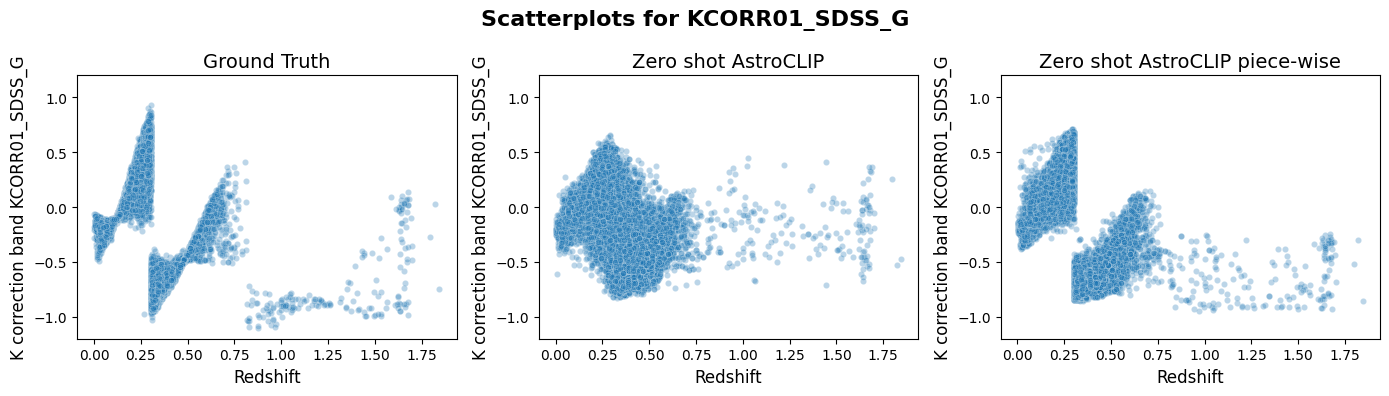

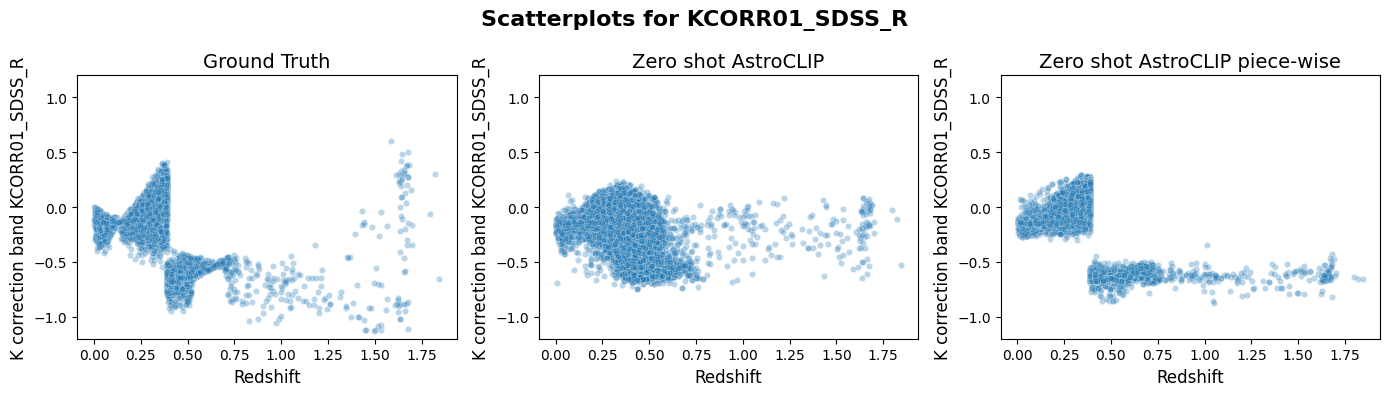

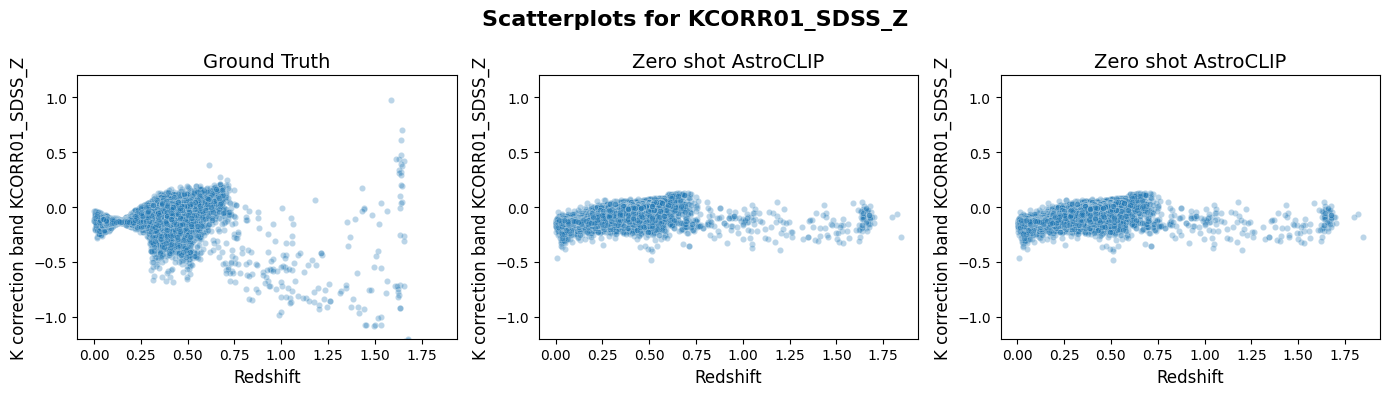

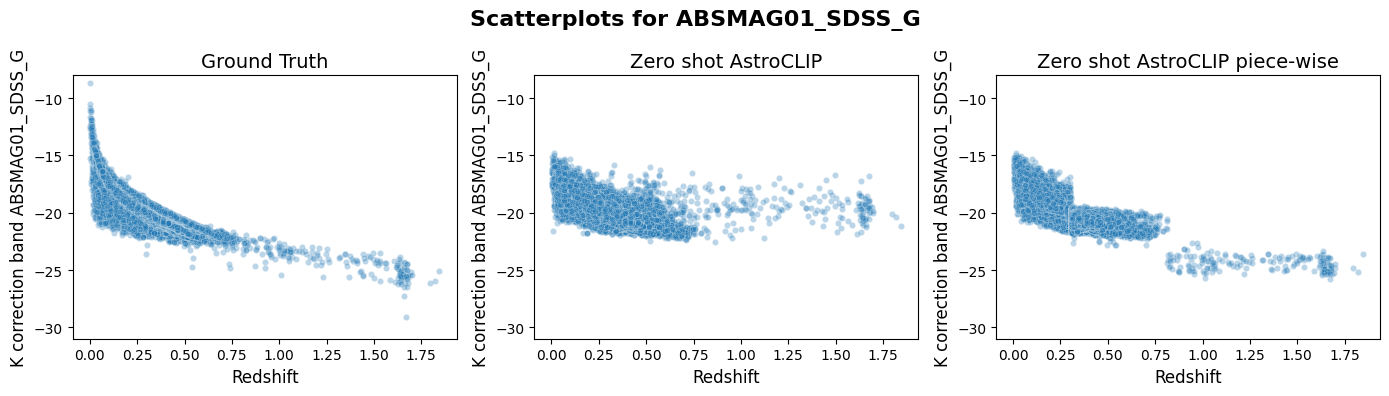

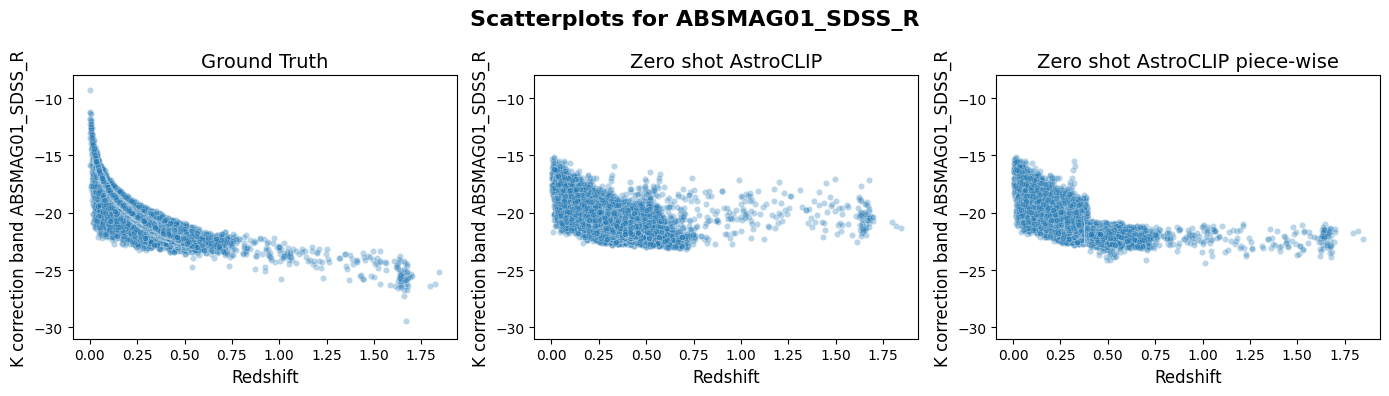

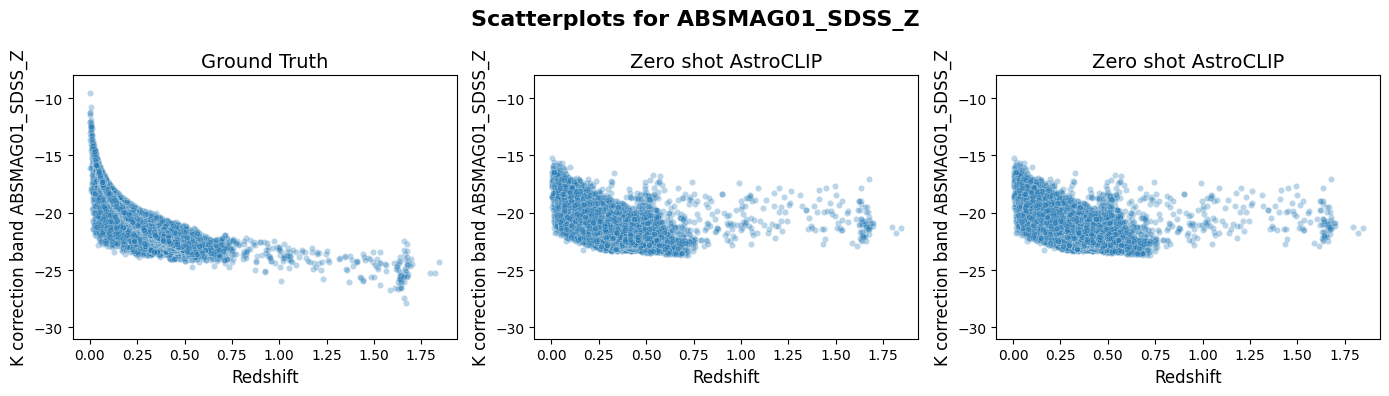

In [32]:
plot_scatterplot("KCORR01_SDSS_G",30,30)
plot_scatterplot("KCORR01_SDSS_R",30,64)
plot_scatterplot("KCORR01_SDSS_Z",100,100)
plot_scatterplot("ABSMAG01_SDSS_G",30,30)
plot_scatterplot("ABSMAG01_SDSS_R",30,30)
plot_scatterplot("ABSMAG01_SDSS_Z",100,100)

In [33]:
def plot_scatterplot_with_density(target_v="KCORR01_SDSS_G", optk=30, optk_piecewise=30):
    redshift_range = (0, 2)
    _, _, _, target, _, z = prepare_dataset_for_visualization(train_df, test_df, redshift_range[0], redshift_range[1], target_v)
    pred = zero_shot_predictions[0][(optk, target_v)]['preds']

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # For each subplot
    for ax, y_values, title in zip(
        axes,
        [target, pred, None],  # Third plot handled separately below
        ['Ground Truth', 'Zero shot AstroCLIP', 'Zero shot AstroCLIP piece-wise']
    ):
        if y_values is not None:
            # Add hexbin plot for density - removed scatter overlay
            hb = ax.hexbin(z, y_values, gridsize=50, cmap='viridis', mincnt=1)
            plt.colorbar(hb, ax=ax, label="Density")
        
        ax.set_title(title, fontsize=14)
        ax.set_xlabel('Redshift', fontsize=12)
        ax.set_ylabel(f'K correction band {target_v}', fontsize=12)

    # Handle third subplot separately
    if target_v[-1] == "G":
        z_piecewise = gt_z_g
    elif target_v[-1] == "R":
        z_piecewise = gt_z_r
    else:
        z_piecewise = []

    if target_v[-1] != "Z":
        pred_piecewise = df[(df['k'] == optk_piecewise) & (df['target'] == target_v)]['pred'].iloc[0]
        hb = axes[2].hexbin(z_piecewise, pred_piecewise, gridsize=50, cmap='viridis', mincnt=1)
        plt.colorbar(hb, ax=axes[2], label="Density")
    else:
        hb = axes[2].hexbin(z, pred, gridsize=50, cmap='viridis', mincnt=1)
        plt.colorbar(hb, ax=axes[2], label="Density")

    # Set Y-axis limits
    ylim = (-1.2, 1.2) if target_v[0] == "K" else (-31, -8)
    for ax in axes:
        ax.set_ylim(ylim[0], ylim[1])

    fig.suptitle(f'Scatterplots with Density for {target_v}', fontsize=16, fontweight='bold')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

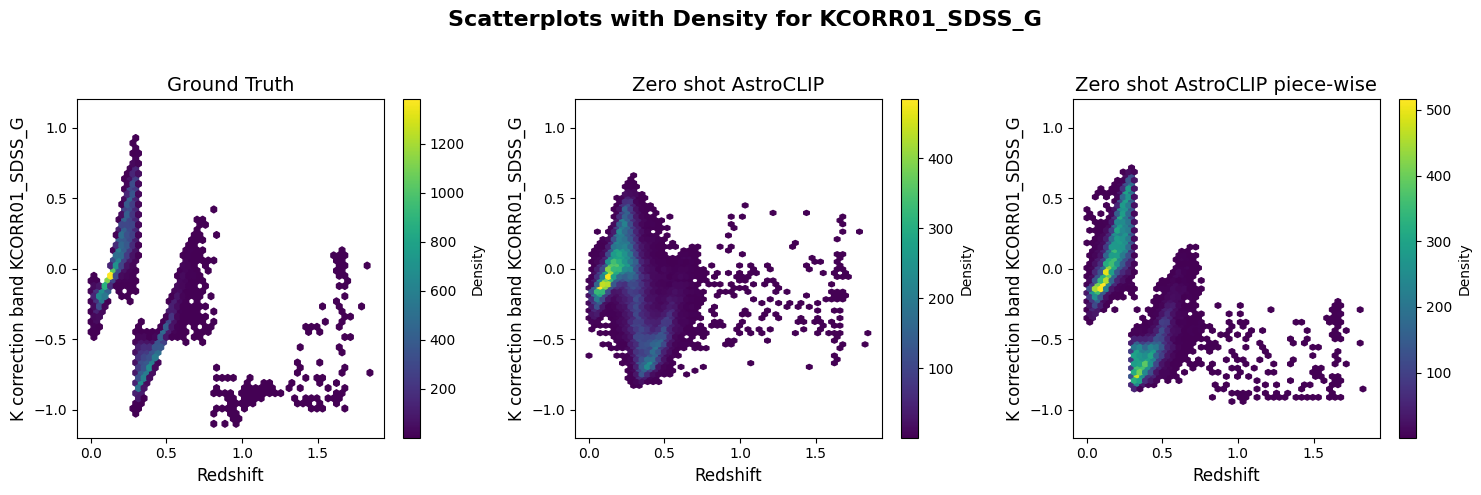

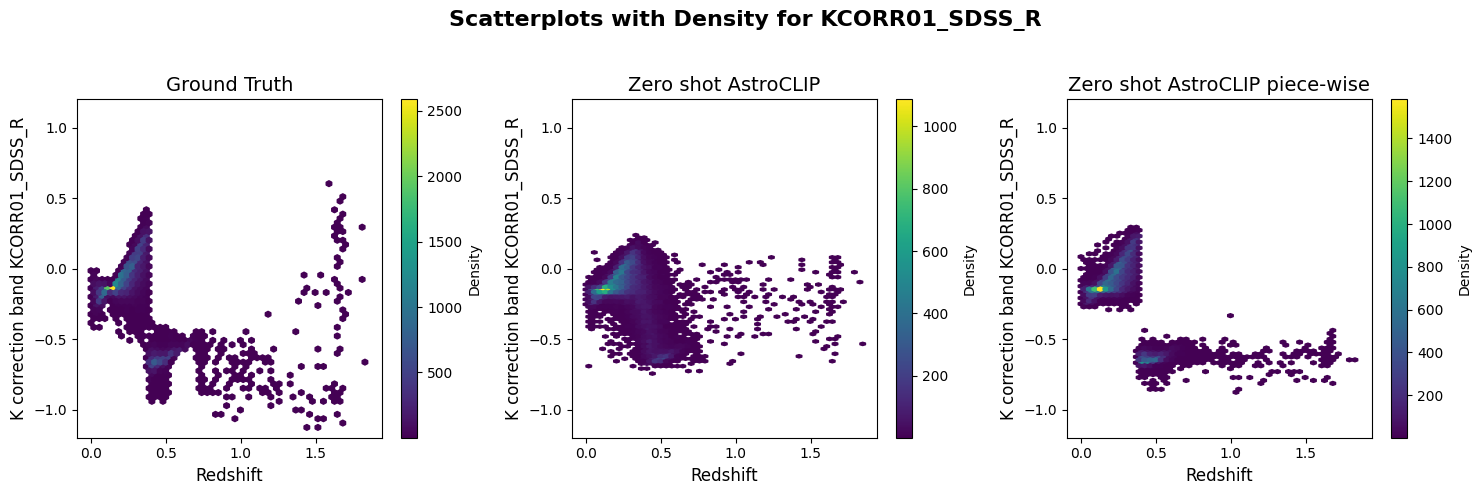

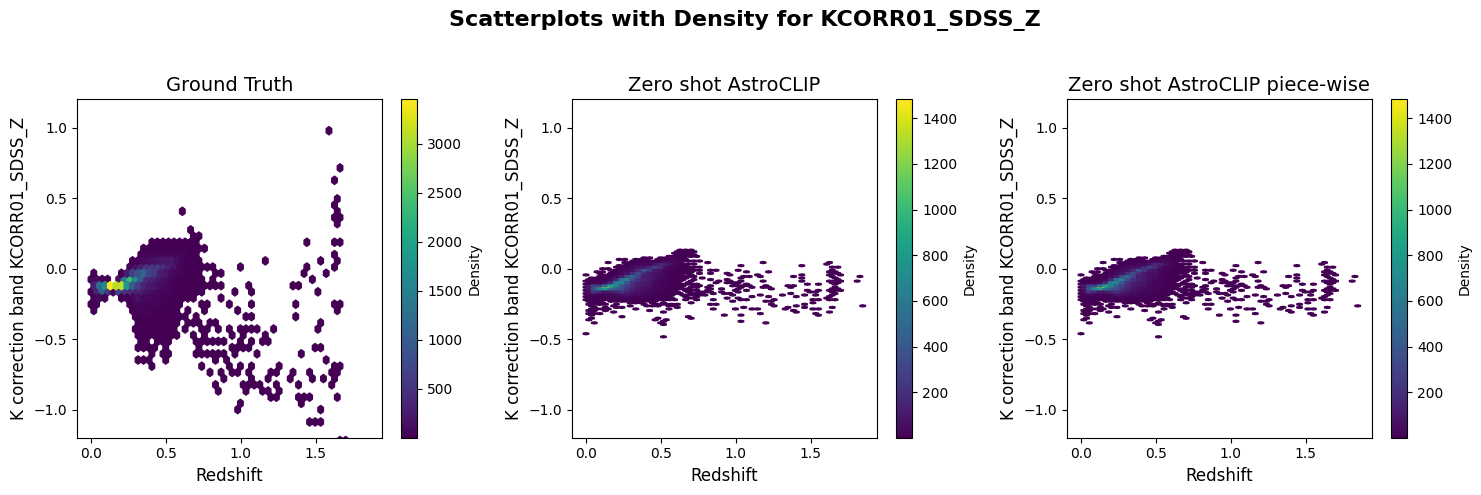

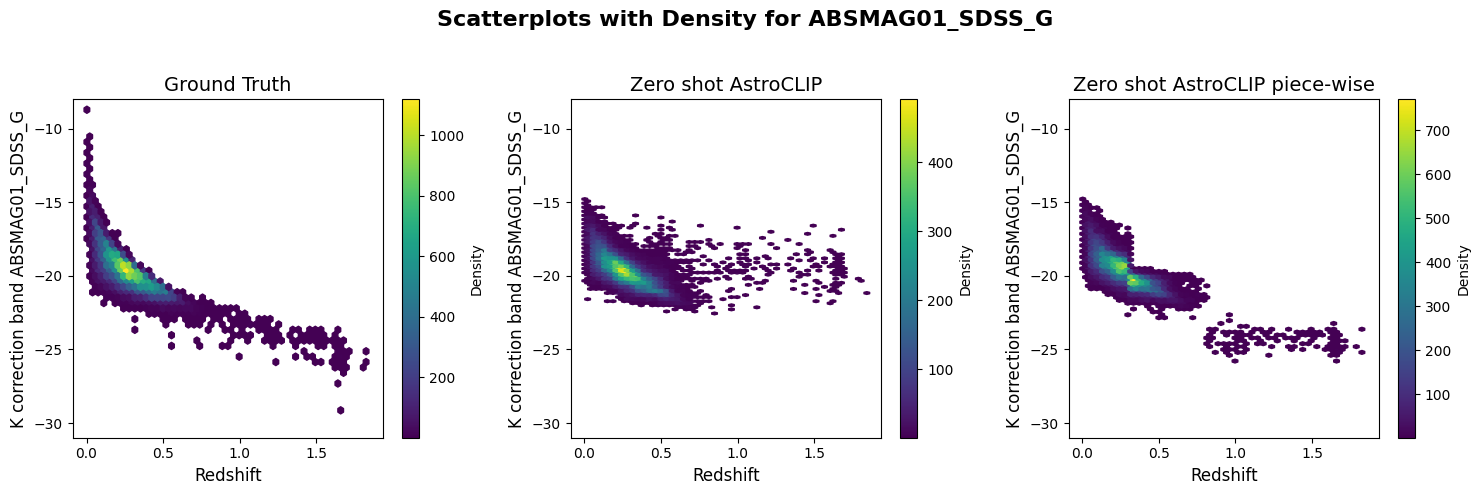

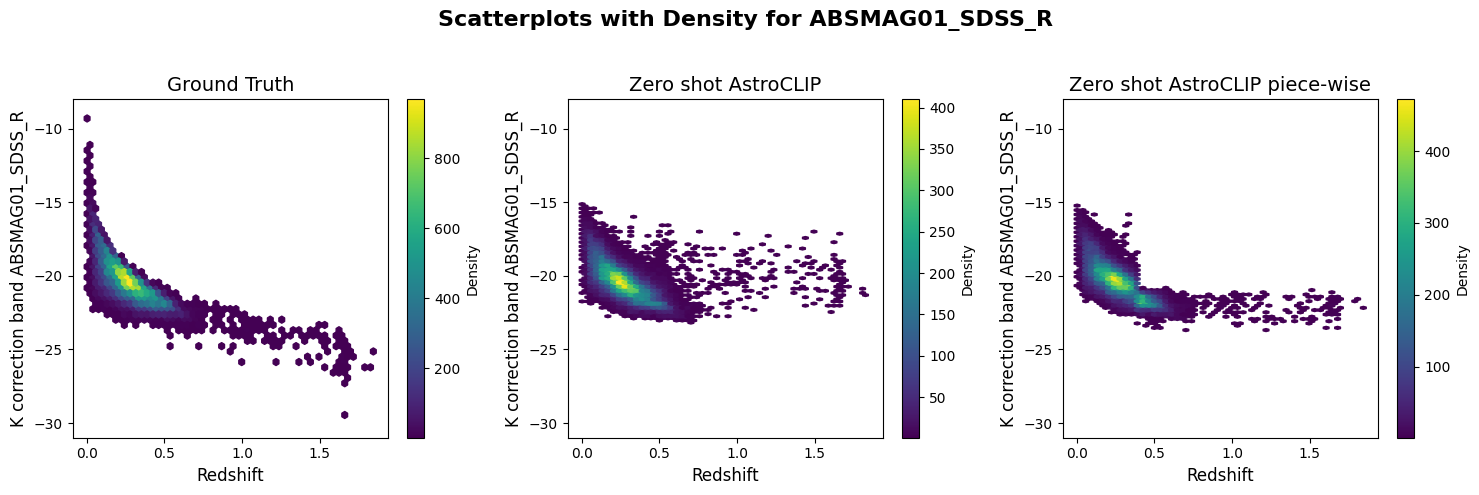

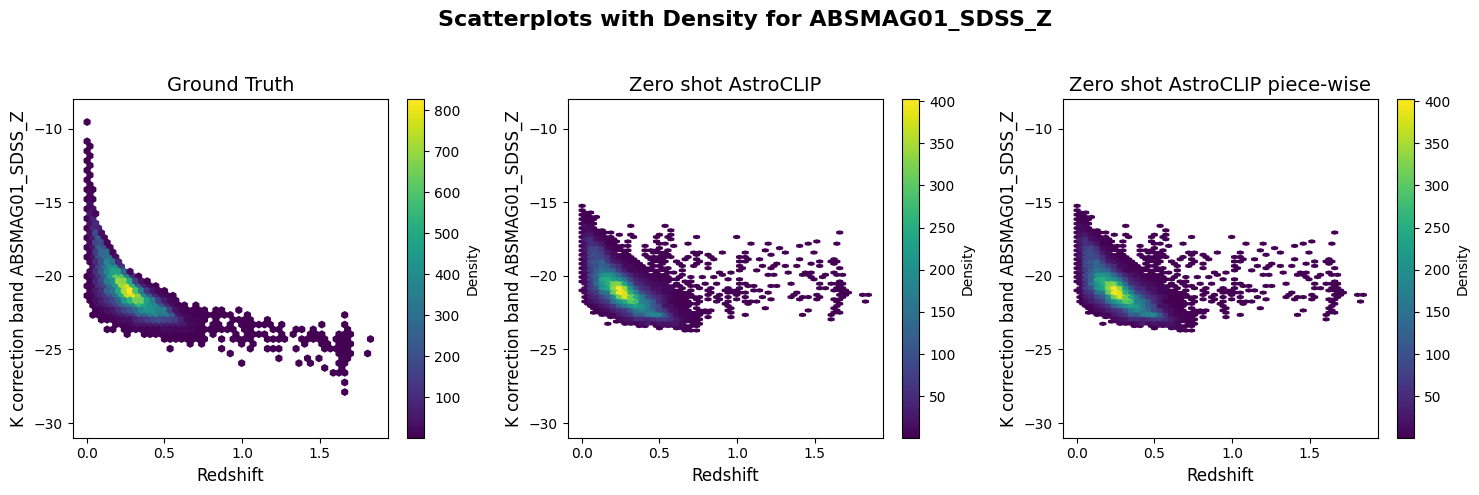

In [34]:
plot_scatterplot_with_density("KCORR01_SDSS_G",30,30)
plot_scatterplot_with_density("KCORR01_SDSS_R",30,64)
plot_scatterplot_with_density("KCORR01_SDSS_Z",100,100)
plot_scatterplot_with_density("ABSMAG01_SDSS_G",30,30)
plot_scatterplot_with_density("ABSMAG01_SDSS_R",30,30)
plot_scatterplot_with_density("ABSMAG01_SDSS_Z",100,100)

Let's plot a last family of scatterplots, this time highlighting the points that have the highest prediction error

In [35]:
def plot_error_comparison(target_v="KCORR01_SDSS_G", optk=30, optk_piecewise=30):
    redshift_range = (0, 2)
    _, _, _, target, _, z = prepare_dataset_for_visualization(train_df, test_df, redshift_range[0], redshift_range[1], target_v)
    
    # Get predictions from single model
    pred = zero_shot_predictions[0][(optk, target_v)]['preds']
    error_single = np.abs(pred - target)
    
    # Get predictions and data for piecewise model
    if target_v[-1] == "G":
        z_piecewise = gt_z_g
    elif target_v[-1] == "R":
        z_piecewise = gt_z_r
    else:
        z_piecewise = []
        
    if target_v[-1] != "Z":
        pred_piecewise = df[(df['k'] == optk_piecewise) & (df['target'] == target_v)]['pred'].iloc[0]
        target_piecewise = df[(df['k'] == optk_piecewise) & (df['target'] == target_v)]['gt'].iloc[0]
        error_piecewise = np.abs(pred_piecewise - target_piecewise)
    else:
        # For Z band, use same data as single model
        pred_piecewise = pred
        target_piecewise = target
        z_piecewise = z
        error_piecewise = error_single
    
    # Create figure with 4 subplots (2x2)
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot for single model
    scatter1 = axes[0,0].scatter(z, target, c=error_single, 
                                cmap='YlOrRd', s=20, alpha=0.5)
    plt.colorbar(scatter1, ax=axes[0,0], label="Absolute Error")
    axes[0,0].set_title('Single Model: Error Distribution', fontsize=12)
    axes[0,0].set_xlabel('Redshift', fontsize=10)
    axes[0,0].set_ylabel(f'True {target_v}', fontsize=10)
    
    hb1 = axes[0,1].hexbin(z, target, C=error_single,
                          reduce_C_function=np.mean,
                          gridsize=50, cmap='YlOrRd')
    plt.colorbar(hb1, ax=axes[0,1], label="Mean Absolute Error")
    axes[0,1].set_title('Single Model: Mean Error Density', fontsize=12)
    axes[0,1].set_xlabel('Redshift', fontsize=10)
    axes[0,1].set_ylabel(f'True {target_v}', fontsize=10)
    
    # Plot for piecewise model - using piecewise-specific data
    scatter2 = axes[1,0].scatter(z_piecewise, target_piecewise, c=error_piecewise,
                                cmap='YlOrRd', s=20, alpha=0.5)
    plt.colorbar(scatter2, ax=axes[1,0], label="Absolute Error")
    axes[1,0].set_title('Piecewise Model: Error Distribution', fontsize=12)
    axes[1,0].set_xlabel('Redshift', fontsize=10)
    axes[1,0].set_ylabel(f'True {target_v}', fontsize=10)
    
    hb2 = axes[1,1].hexbin(z_piecewise, target_piecewise, C=error_piecewise,
                          reduce_C_function=np.mean,
                          gridsize=50, cmap='YlOrRd')
    plt.colorbar(hb2, ax=axes[1,1], label="Mean Absolute Error")
    axes[1,1].set_title('Piecewise Model: Mean Error Density', fontsize=12)
    axes[1,1].set_xlabel('Redshift', fontsize=10)
    axes[1,1].set_ylabel(f'True {target_v}', fontsize=10)
    
    # Set Y-axis limits for all plots
    ylim = (-1.2, 1.2) if target_v[0] == "K" else (-31, -8)
    for ax_row in axes:
        for ax in ax_row:
            ax.set_ylim(ylim[0], ylim[1])
    
    # Ensure all colorbars have the same scale for fair comparison
    vmax = max(error_single.max(), error_piecewise.max())
    scatter1.set_clim(0, vmax)
    scatter2.set_clim(0, vmax)
    hb1.set_clim(0, vmax)
    hb2.set_clim(0, vmax)
    
    fig.suptitle(f'Error Analysis Comparison for {target_v}', fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

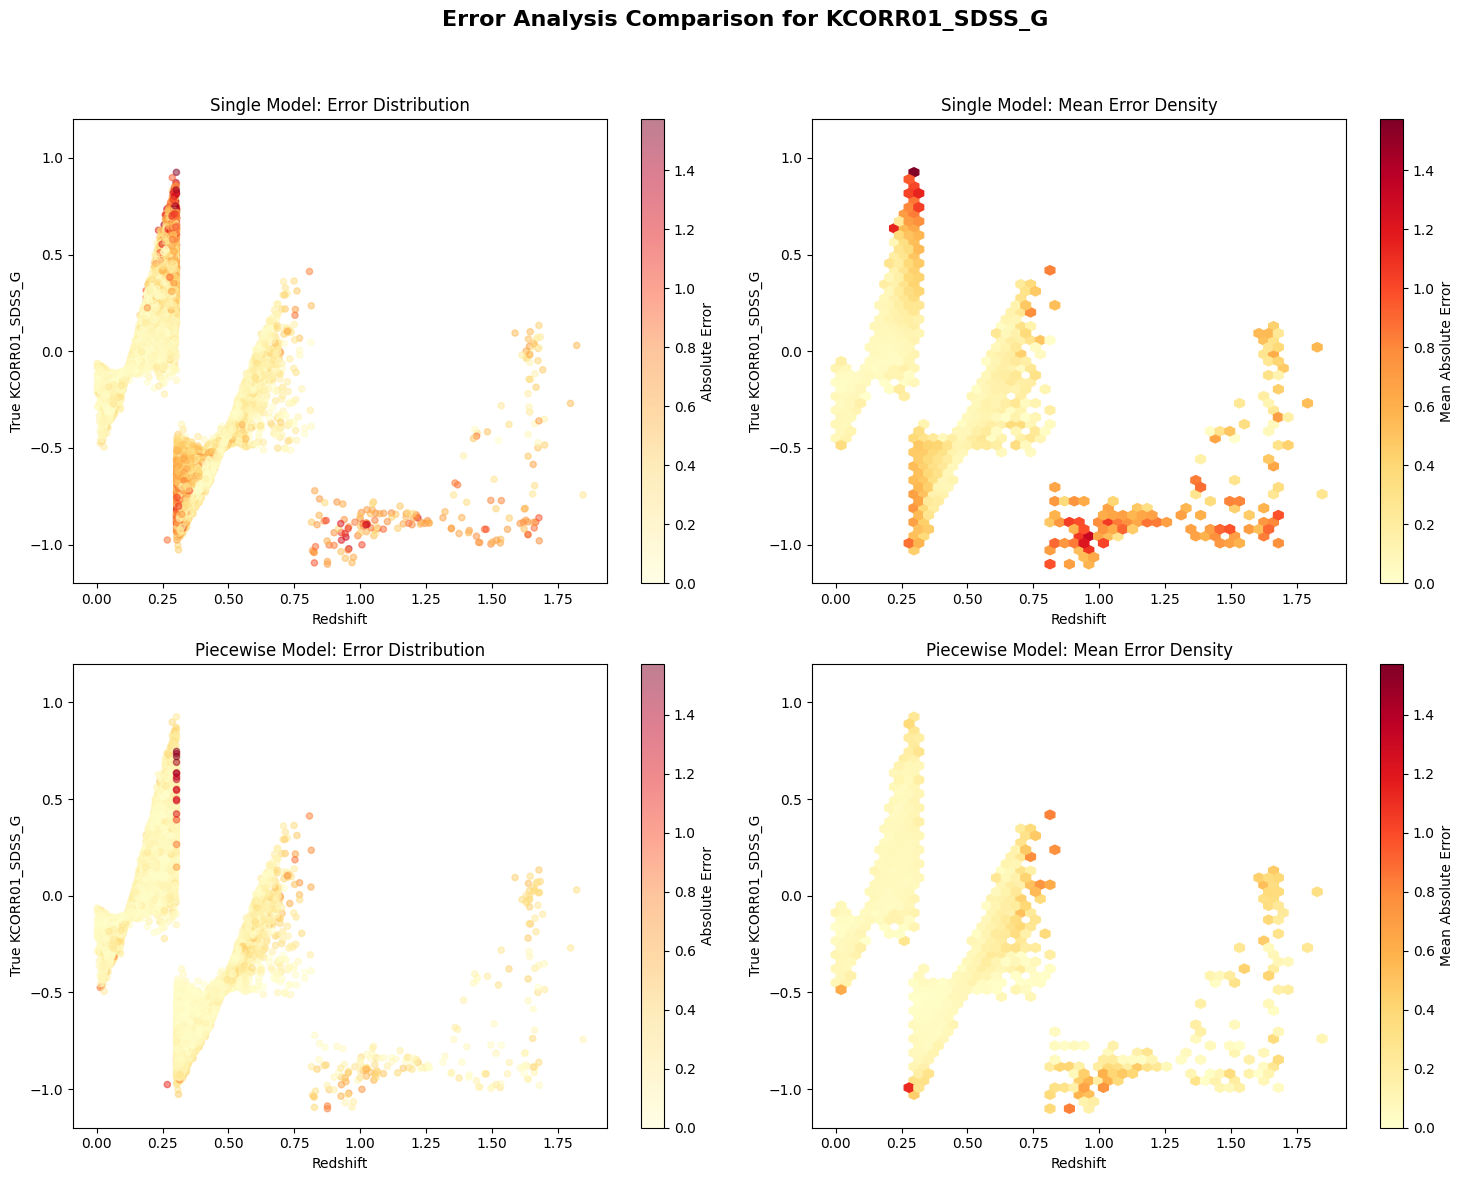

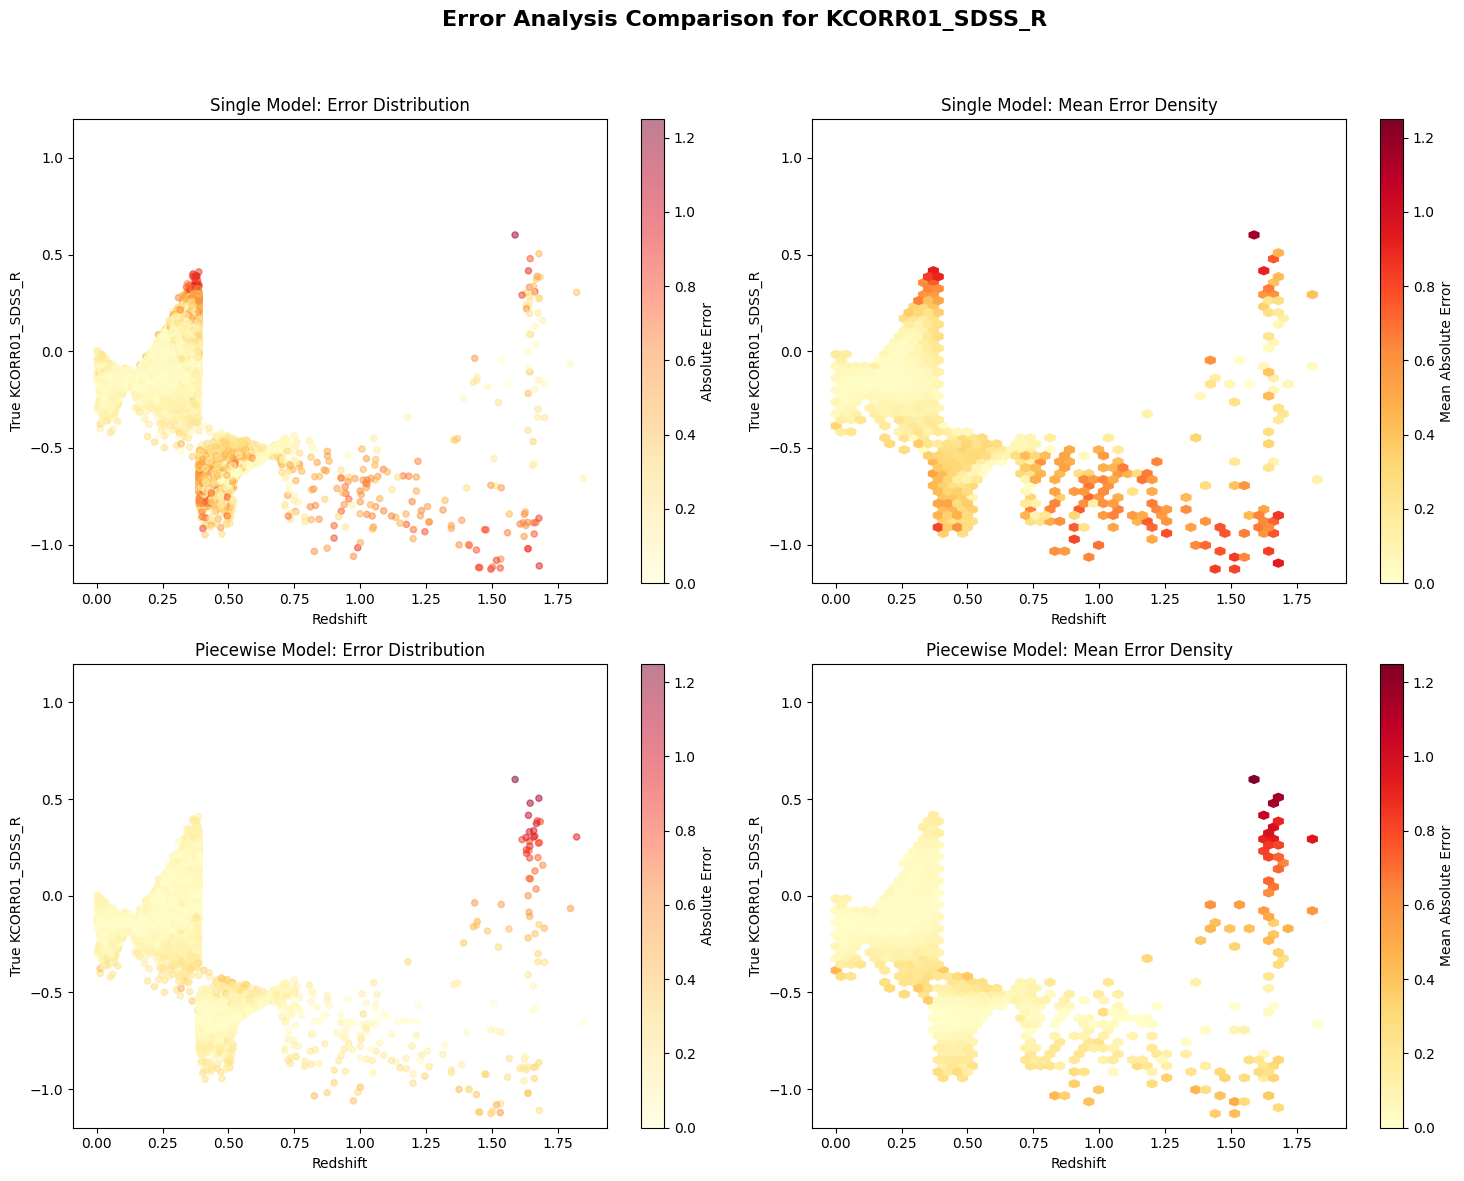

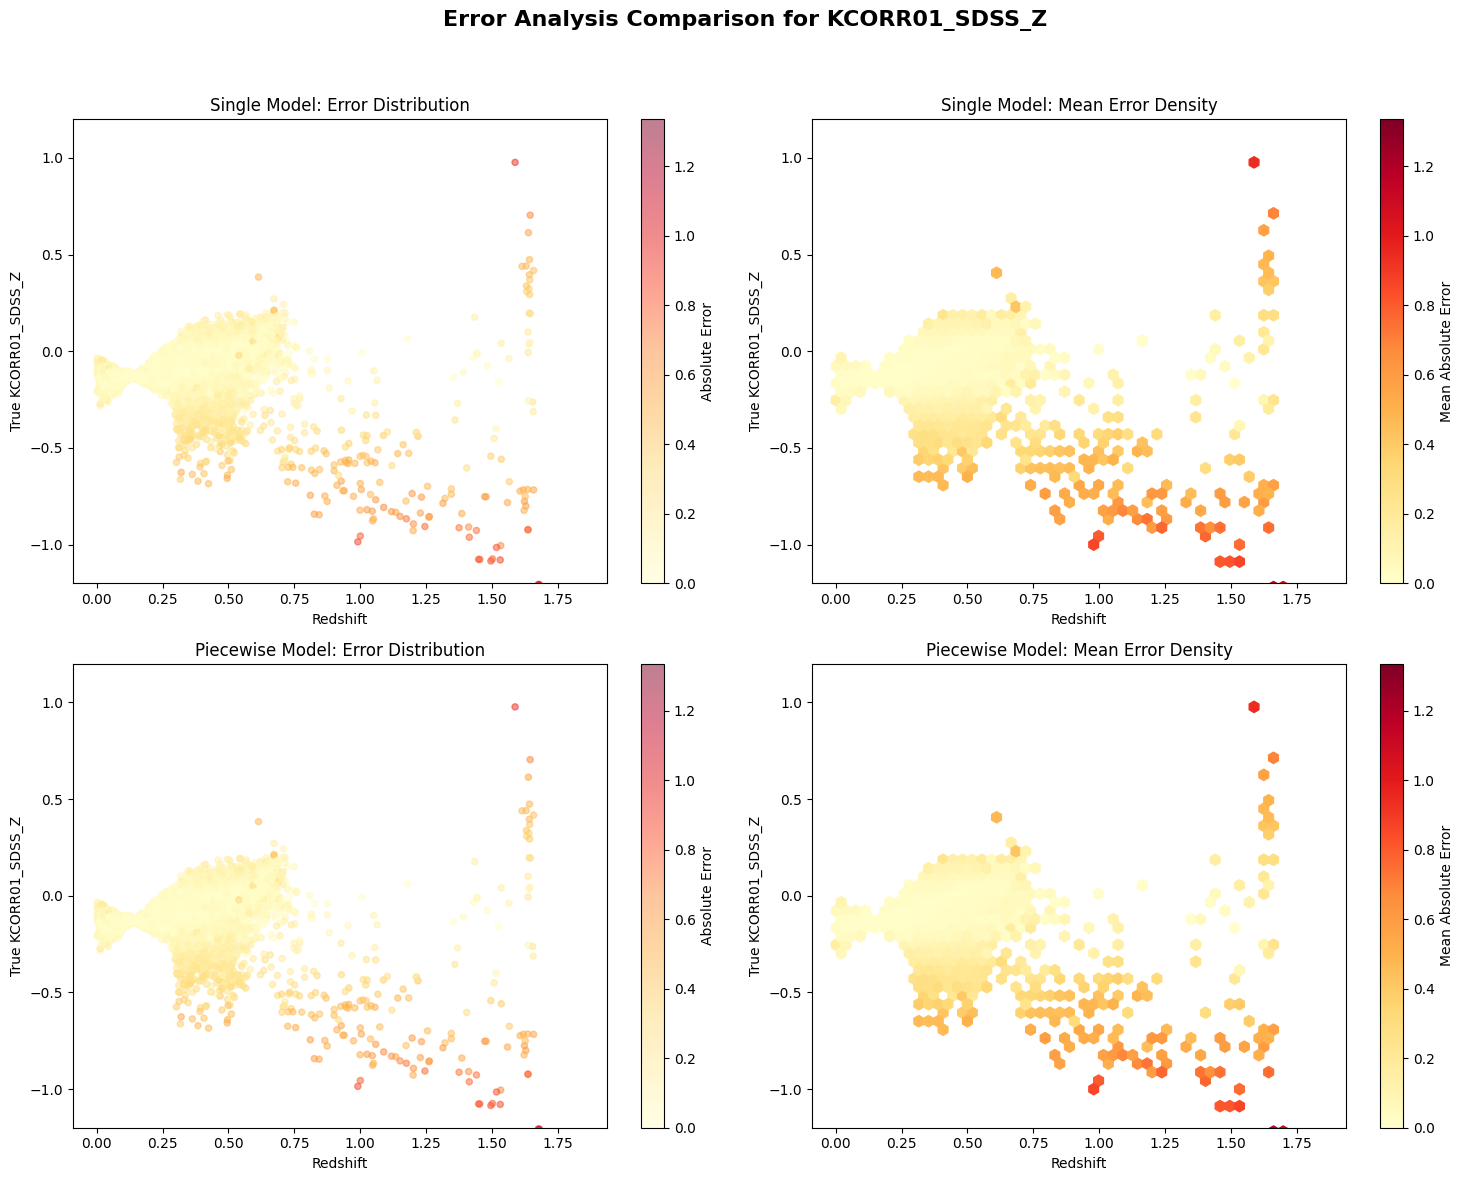

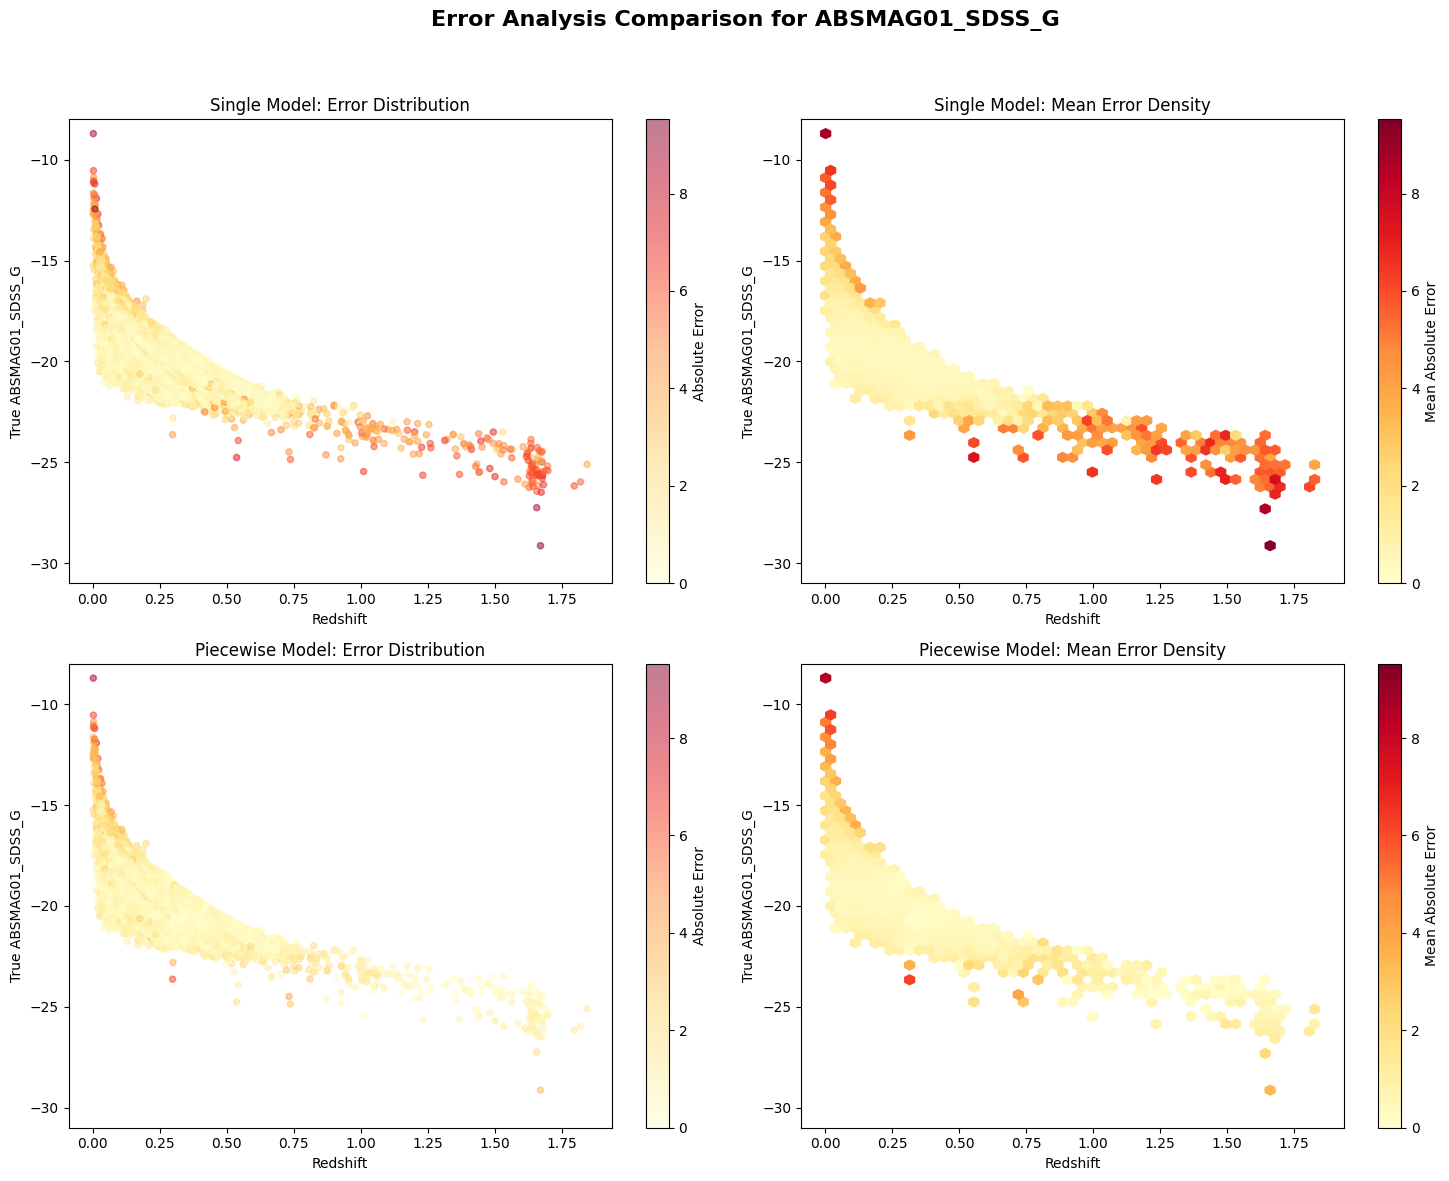

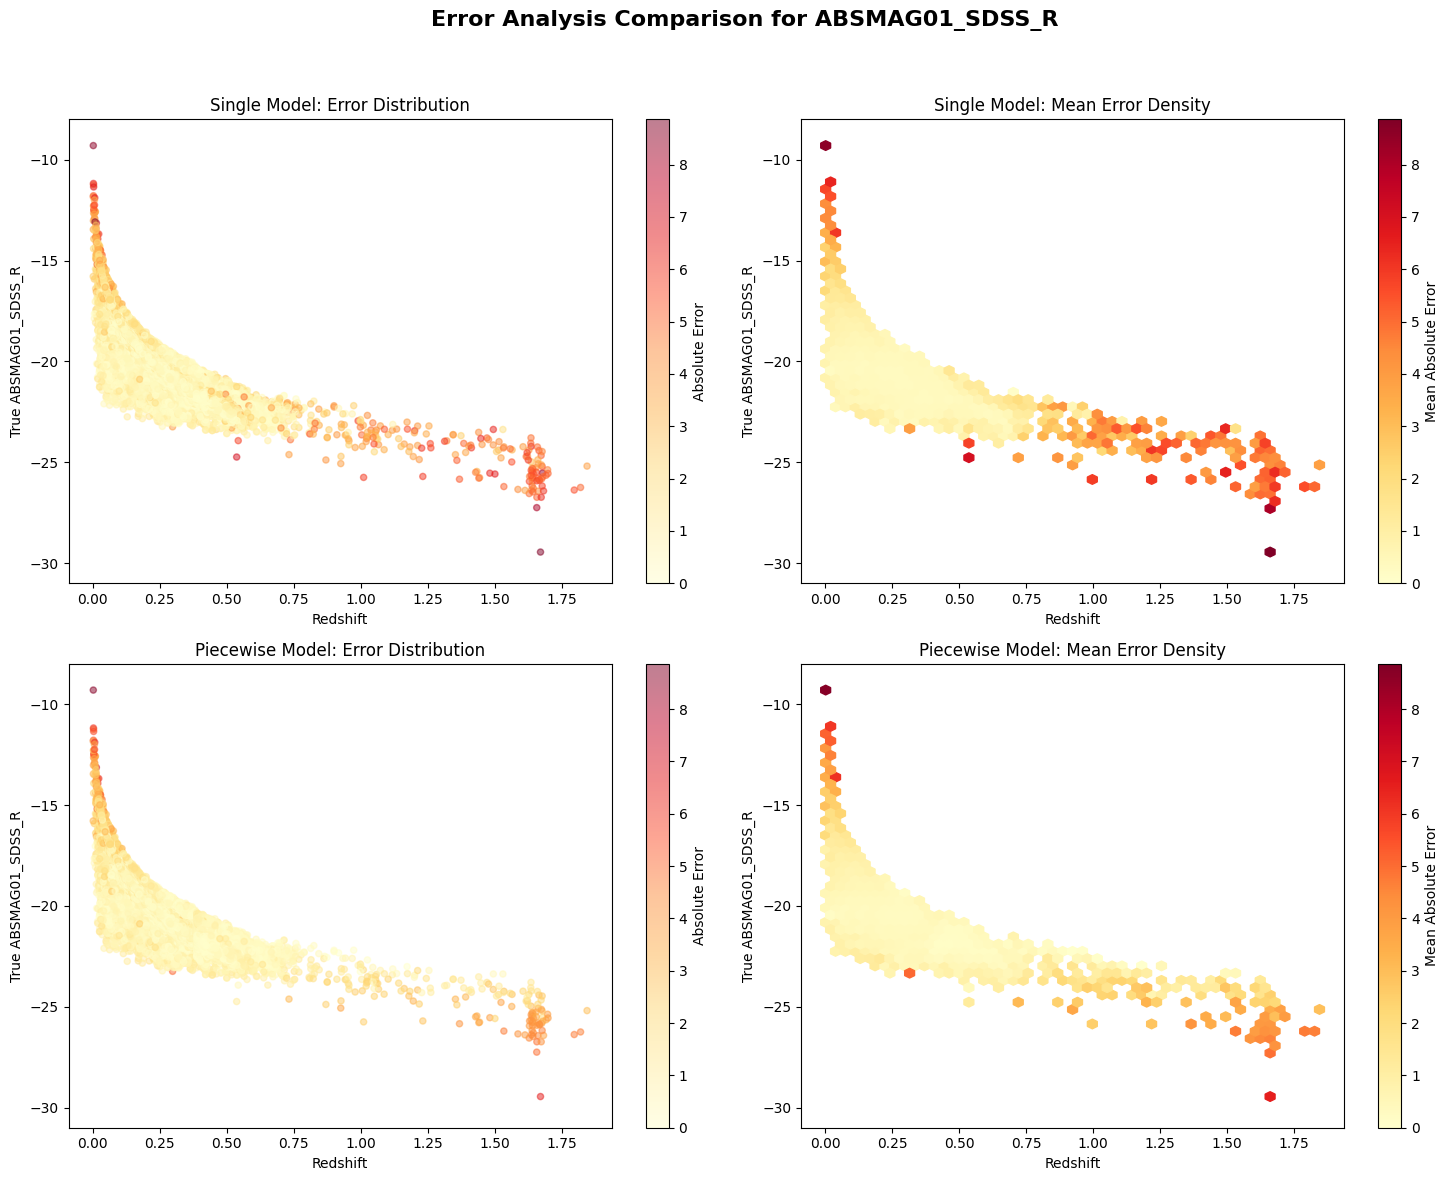

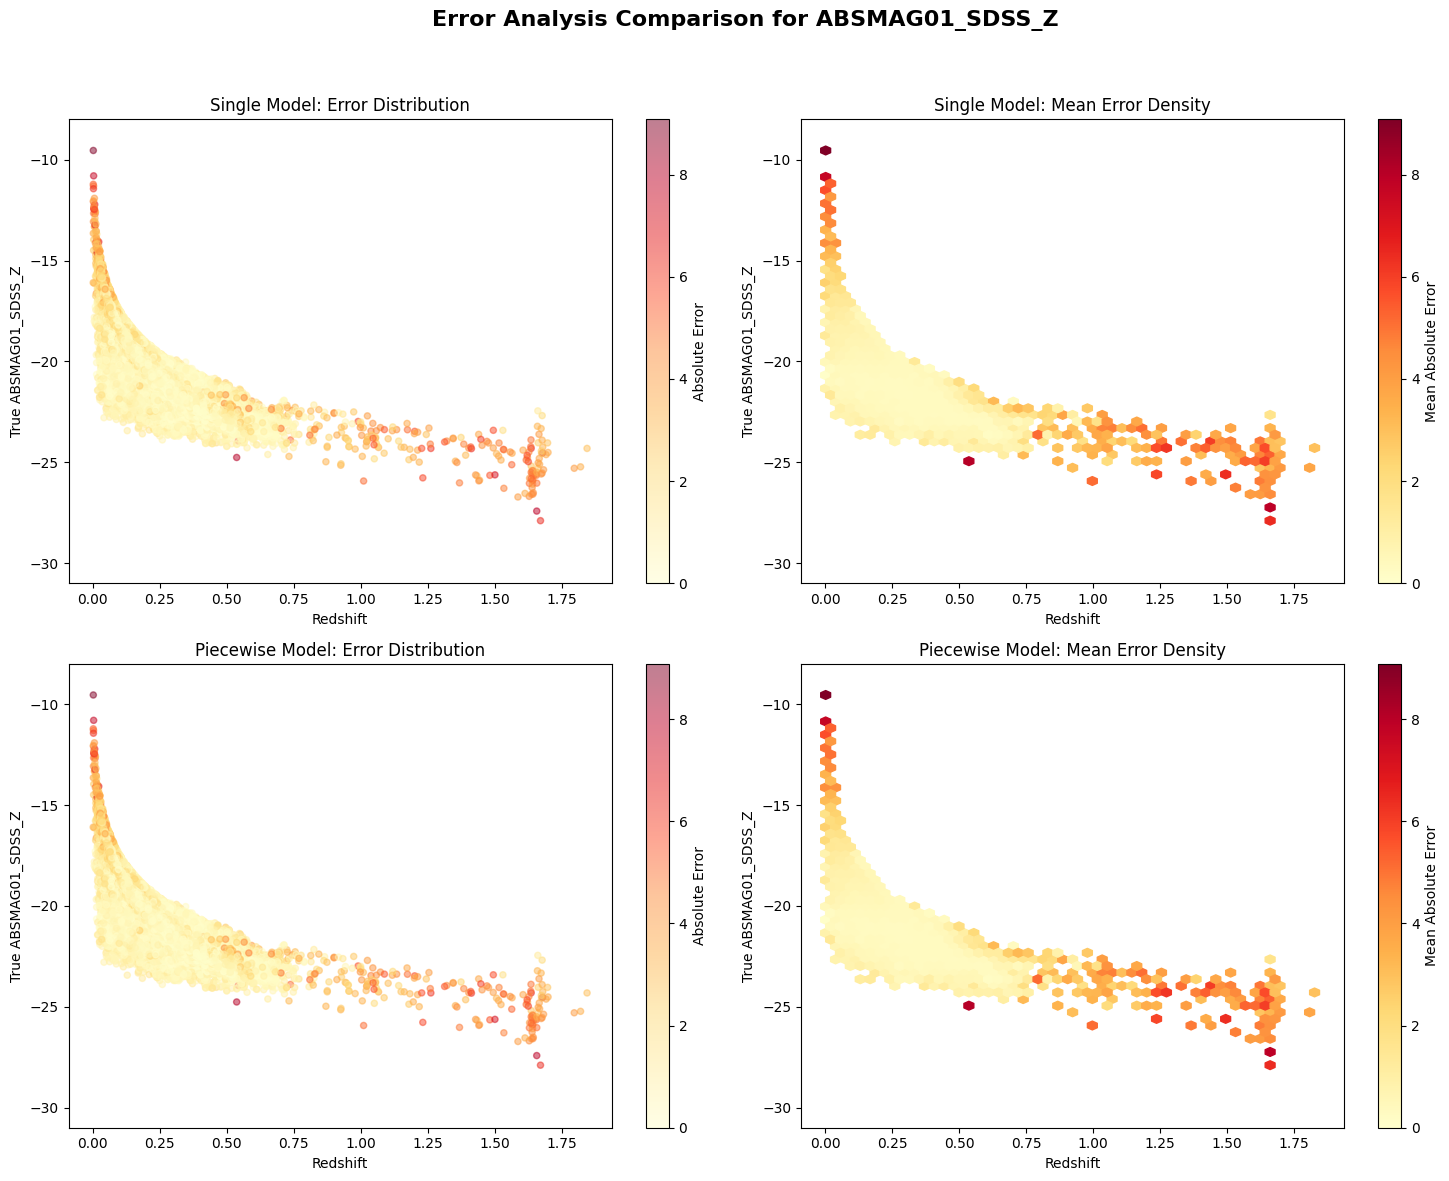

In [36]:
plot_error_comparison("KCORR01_SDSS_G",30,30)
plot_error_comparison("KCORR01_SDSS_R",30,64)
plot_error_comparison("KCORR01_SDSS_Z",100,100)
plot_error_comparison("ABSMAG01_SDSS_G",30,30)
plot_error_comparison("ABSMAG01_SDSS_R",30,100)
plot_error_comparison("ABSMAG01_SDSS_Z",100,100)

These plots are quite revealing. When it comes to K corrections, the models struggle to predict points in the boundaries of the band jumps AND in areas of high redshift, which are areas of low-density in the training data as well.

The ABSMAG plots show that the models struggle to predict values in the tails of the distributions. These may be funny objects, or simply under-represented objects in the training dataset.

### Error analysis plots

In [37]:
def plot_scatter(
    preds: np.ndarray,
    ground_truth: np.ndarray,
    data_lower_lim: float = -1,
    data_upper_lim: float = 1,
    varname = "KCORR01_SDSS_R",
    title = "",
    ax = None
) -> None:
    """Functionality to plot redshift scatter plots for different models."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5))

    sns.scatterplot(ax=ax, x=ground_truth, y=preds, s=5, color=".15")
    sns.histplot(ax=ax, x=ground_truth, y=preds, bins=50, pthresh=0.1, cmap="mako")
    sns.kdeplot(ax=ax, x=ground_truth, y=preds, levels=5, color="k", linewidths=1)

    ax.plot(data_lower_lim, data_upper_lim * 1.1, "--", linewidth=1.5, alpha=0.5, color="grey")
    ax.plot([data_lower_lim, data_upper_lim], [data_lower_lim, data_upper_lim], '--', color='red', linewidth=1)
    ax.set_xlim(data_lower_lim, data_upper_lim)
    ax.set_ylim(data_lower_lim, data_upper_lim)
    ax.set_title(title, fontsize=25)
    ax.set_ylabel(varname, fontsize=25)

def plot_scatter_pair(target_v="KCORR01_SDSS_G", optk=30, optk_piecewise=30):
    redshift_range = (0,2)
    _, _, _, target, _, z = prepare_dataset_for_visualization(train_df, test_df, redshift_range[0], redshift_range[1], target_v)
    pred = zero_shot_predictions[0][(optk,target_v)]['preds']   

    if target_v[-1] != "Z":
        pred_piecewise = df[(df['k'] == optk_piecewise) & (df['target'] == target_v)]['pred'].iloc[0]
        target_piecewise = df[(df['k'] == optk_piecewise) & (df['target'] == target_v)]['gt'].iloc[0]
    else:
        # For Z band, use same data as single model
        pred_piecewise = pred
        target_piecewise = target

    ylim = (-1.2, 1.2) if target_v[0] == "K" else (-31, -8)

    # Create a single figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    
    plot_scatter(pred, target, varname=target_v, 
                data_lower_lim=ylim[0], data_upper_lim=ylim[1], 
                title="AstroCLIP Single Model", ax=ax1)
    
    plot_scatter(pred_piecewise, target_piecewise, varname=target_v,
                data_lower_lim=ylim[0], data_upper_lim=ylim[1], 
                title="AstroCLIP Piecewise Model", ax=ax2)
    
    plt.tight_layout()
    plt.show()

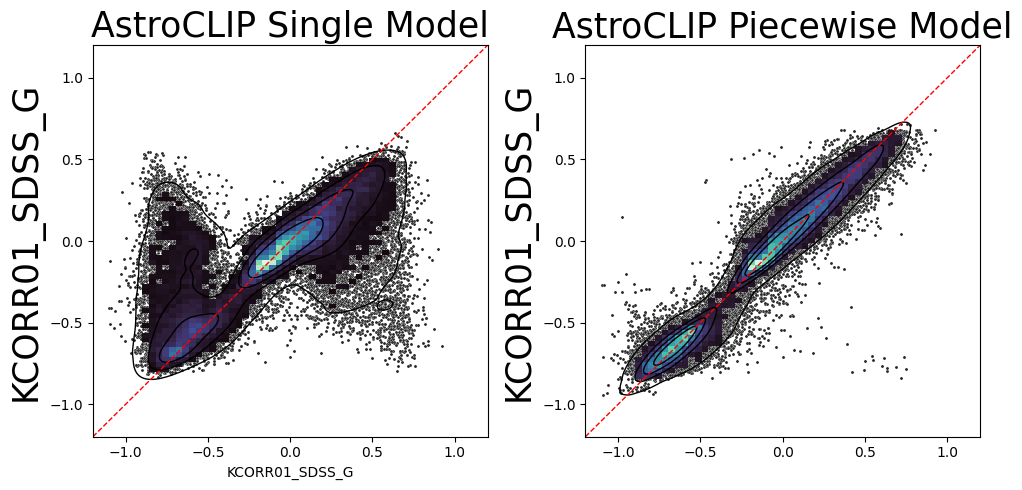

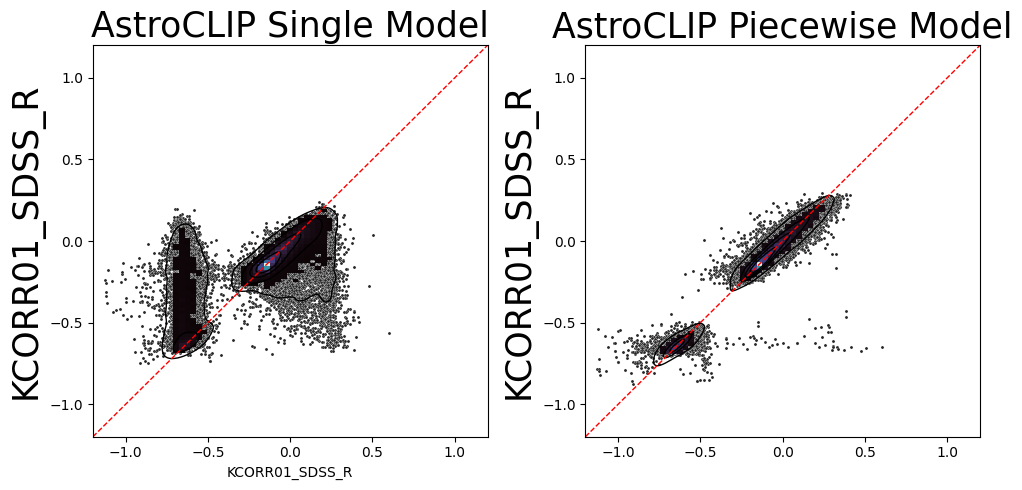

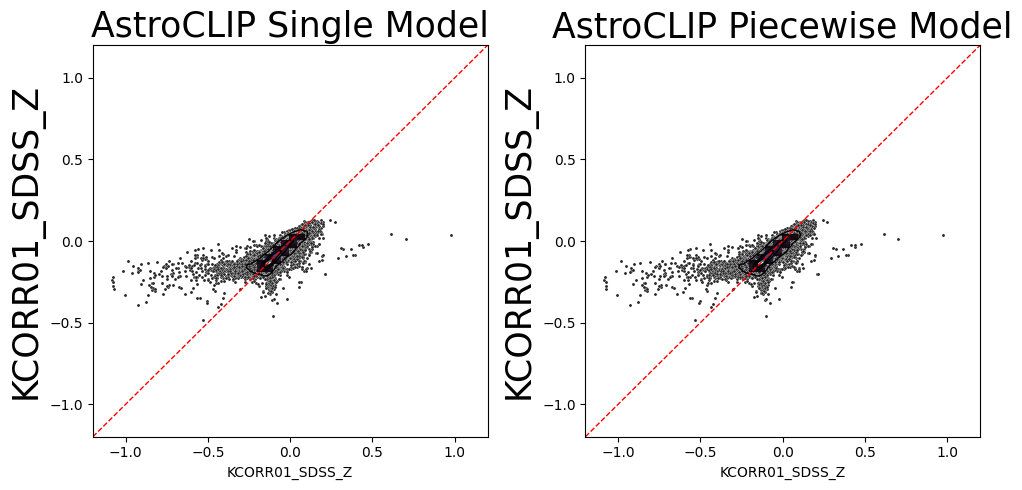

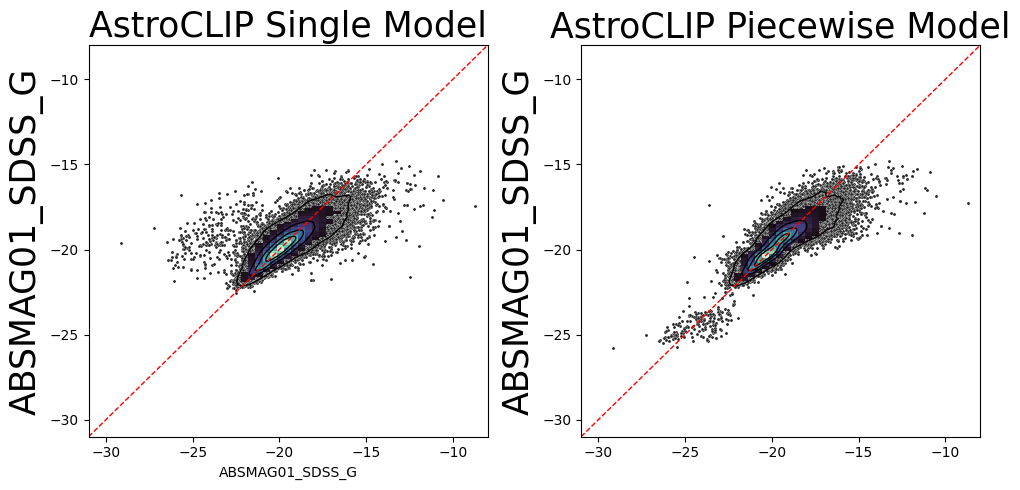

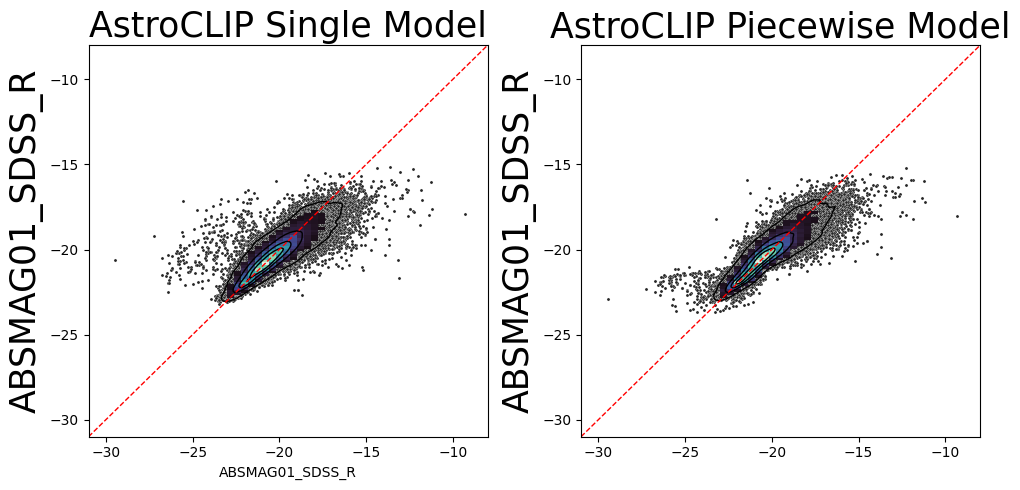

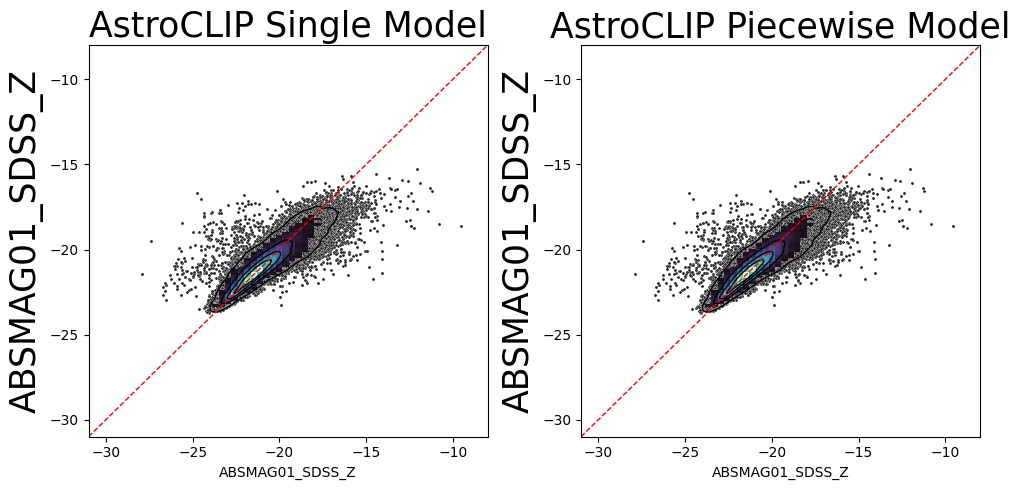

In [38]:
plot_scatter_pair("KCORR01_SDSS_G",30,30)
plot_scatter_pair("KCORR01_SDSS_R",30,64)
plot_scatter_pair("KCORR01_SDSS_Z",100,100)
plot_scatter_pair("ABSMAG01_SDSS_G",30,30)
plot_scatter_pair("ABSMAG01_SDSS_R",30,30)
plot_scatter_pair("ABSMAG01_SDSS_Z",100,100)

In [40]:
def plot_error_distribution(
    preds: np.ndarray,
    ground_truth: np.ndarray,
    title = "",
    ax = None,
    xlims = None
) -> None:
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5))

    # Compute the error
    error = preds - ground_truth
    sns.histplot(error, ax=ax, kde=True, color="purple", bins=50)
    ax.axvline(0, color='red', linestyle='--', label="No Error")
    ax.set_xlabel("Error (AstroCLIP Estimate - VAC Estimate)", fontsize=14)
    ax.set_ylabel("Frequency", fontsize=14)
    ax.set_title(title, fontsize=25)
    if xlims is not None:
        ax.set_xlim(xlims)
    ax.legend()

def plot_error_distribution_pair(target_v="KCORR01_SDSS_G", optk=30, optk_piecewise=30):
    redshift_range = (0,2)
    _, _, _, target, _, z = prepare_dataset_for_visualization(train_df, test_df, redshift_range[0], redshift_range[1], target_v)
    pred = zero_shot_predictions[0][(optk,target_v)]['preds']   

    if target_v[-1] != "Z":
        pred_piecewise = df[(df['k'] == optk_piecewise) & (df['target'] == target_v)]['pred'].iloc[0]
        target_piecewise = df[(df['k'] == optk_piecewise) & (df['target'] == target_v)]['gt'].iloc[0]
    else:
        # For Z band, use same data as single model
        pred_piecewise = pred
        target_piecewise = target

    # Calculate common xlims from both error distributions
    error1 = pred - target
    error2 = pred_piecewise - target_piecewise
    min_error = min(error1.min(), error2.min())
    max_error = max(error1.max(), error2.max())
    xlims = (min_error, max_error)

    # Create a single figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    
    plot_error_distribution(pred, target, 
                title="AstroCLIP Single Model", ax=ax1, xlims=xlims)
    
    plot_error_distribution(pred_piecewise, target_piecewise, 
                title="AstroCLIP Piecewise Model", ax=ax2, xlims=xlims)
    
    plt.suptitle(target_v, fontsize=25, y=1.05)
    plt.tight_layout()
    plt.show()

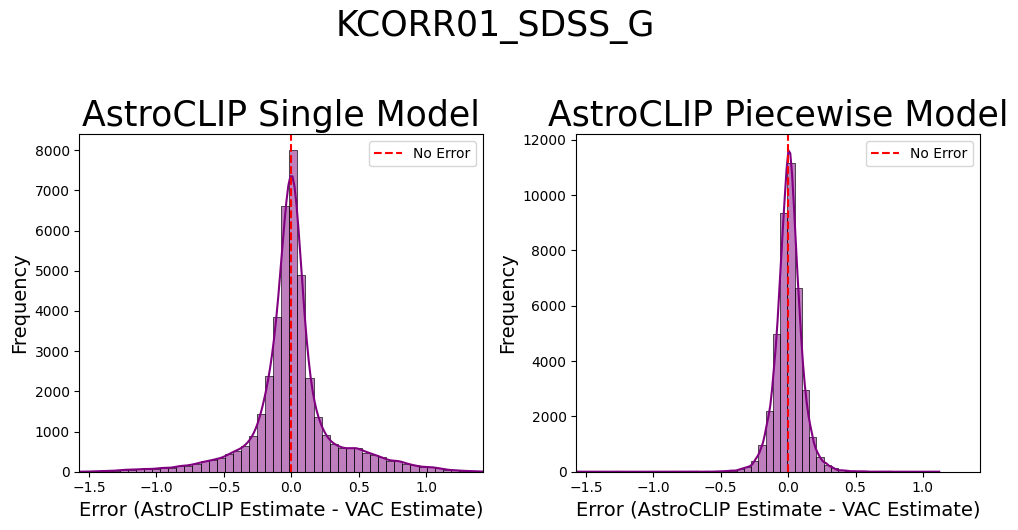

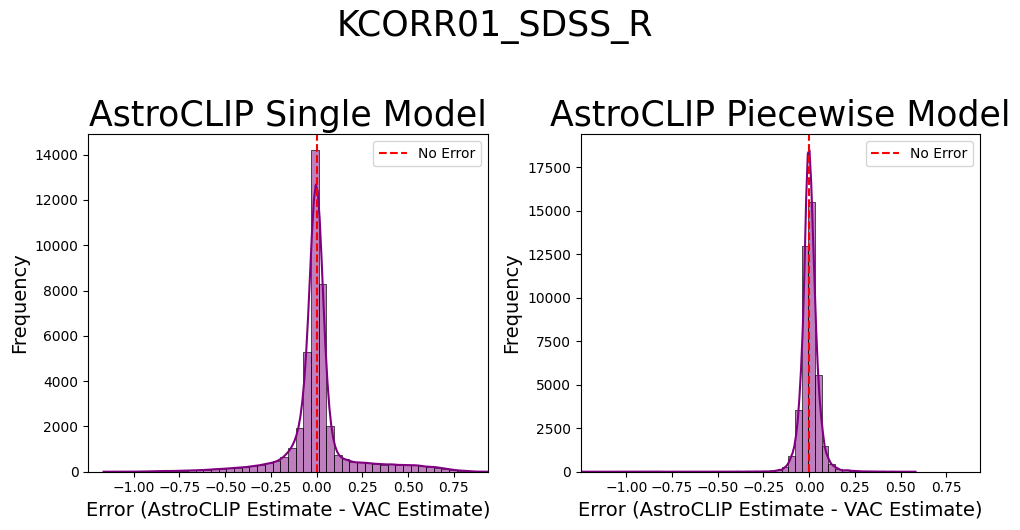

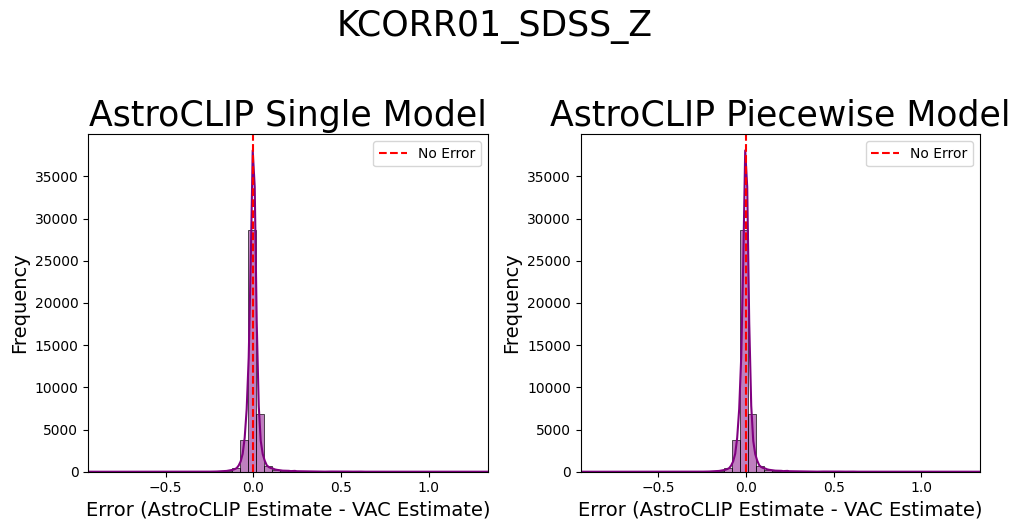

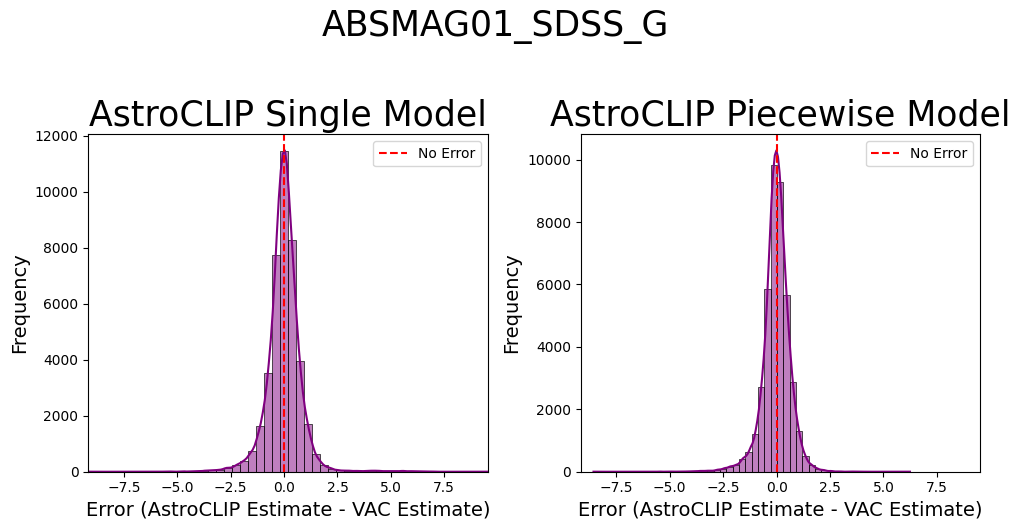

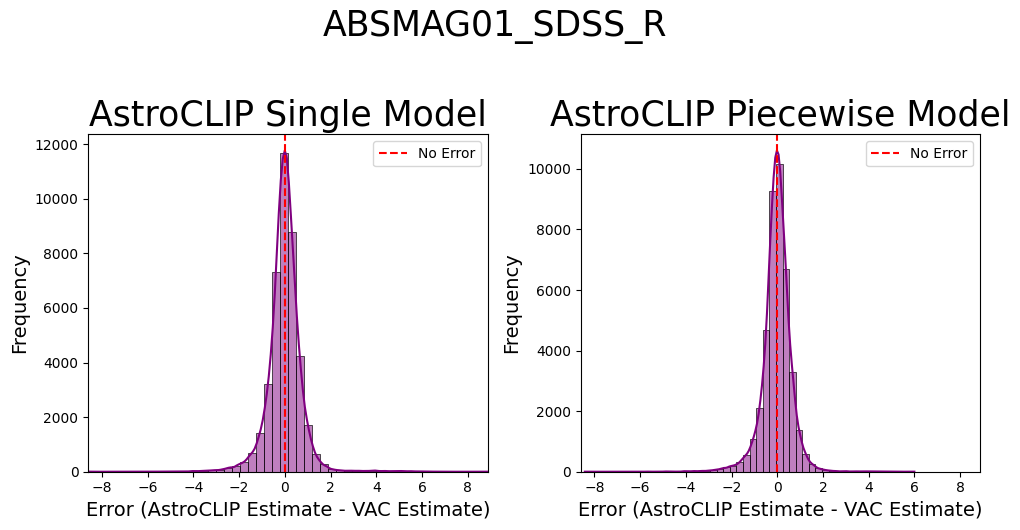

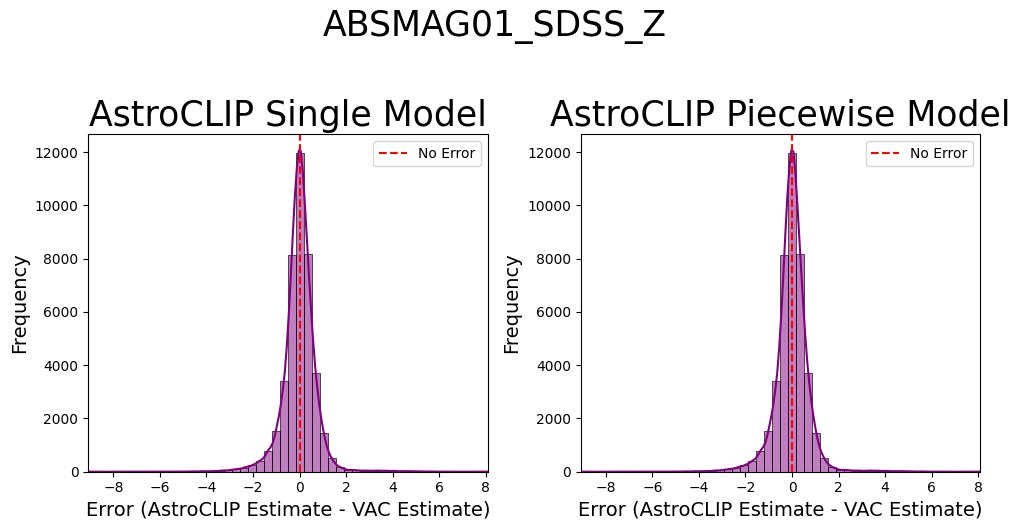

In [41]:
plot_error_distribution_pair("KCORR01_SDSS_G",30,30)
plot_error_distribution_pair("KCORR01_SDSS_R",30,64)
plot_error_distribution_pair("KCORR01_SDSS_Z",100,100)
plot_error_distribution_pair("ABSMAG01_SDSS_G",30,30)
plot_error_distribution_pair("ABSMAG01_SDSS_R",30,30)
plot_error_distribution_pair("ABSMAG01_SDSS_Z",100,100)

# Few shot

In [42]:
import matplotlib.pyplot as plt

In [62]:
from utils.data_utils import collect_predictions

def r2_score_ignorenan(y_true, y_pred):
    """Computes R² score while ignoring NaN values in y_true and y_pred."""
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)  # Keep only non-NaN values
    if np.sum(mask) == 0:  # If all values are NaN, return NaN
        return np.nan
    return r2_score(y_true[mask], y_pred[mask])

def pretty_print_table(df, target_and_predictor_pairs, caption=""):
    # List to store results
    results = []
    
    for (gt, pred) in target_and_predictor_pairs:
        count = sum(~np.isnan(df[pred]))
        mae = np.mean(np.abs(df[pred] - df[gt]))
        r2 = r2_score_ignorenan(df[gt], df[pred])
        mse = np.mean((df[pred] - df[gt]) ** 2)
        rmse = np.sqrt(mse)
        
        results.append({"Target": gt, "Predictor": pred, "MAE": mae, "R²": r2, "RMSE": rmse, "Count": count})
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    # Style it
    styled_df = results_df.style.set_table_styles(
        [
            {"selector": "th", "props": [("font-size", "14px"), ("text-align", "center")]},
            {"selector": "td", "props": [("font-size", "13px"), ("text-align", "center")]}
        ]
    ).set_caption("📊 Model Performance Metrics "+caption)
    
    # Display the styled DataFrame
    display(styled_df)


## Few shot experiment I: A MLP with architecture [1024, 512, 512, 256]

In [47]:
test_path = "../data/test_df_kcorr_panda.h5"
tensorboard_log_dir = "../tensorboard_logs/AstroCLIP"
experiment_name = "mlp"

In [68]:
def print_stats(df,arch="[1024, 512, 512, 256]",redshift=False):

    suffix = arch+"_"+str(redshift)
    
    # Based on this dataset, we can tell whether few-shot predictors are good ro not.
    # Let's start with entire variable comparisons
    TARGET_AND_PREDICTOR_PAIRS = [ ("KCORR01_SDSS_R", "KCORR01_SDSS_R_0_2_MLP_"+suffix),
                                   ("KCORR01_SDSS_G", "KCORR01_SDSS_G_0_2_MLP_"+suffix),
                                   ("KCORR01_SDSS_Z", "KCORR01_SDSS_Z_0_2_MLP_"+suffix),
                                   ("ABSMAG01_SDSS_R", "ABSMAG01_SDSS_R_0_2_MLP_"+suffix),
                                   ("ABSMAG01_SDSS_G", "ABSMAG01_SDSS_G_0_2_MLP_"+suffix),
                                   ("ABSMAG01_SDSS_Z", "ABSMAG01_SDSS_Z_0_2_MLP_"+suffix)]
    pretty_print_table(df, TARGET_AND_PREDICTOR_PAIRS, "SINGLE MODEL STATS")

    # Piecewise comparisons
    TARGET_AND_PREDICTOR_PAIRS = [ ("KCORR01_SDSS_R", "KCORR01_SDSS_R_0.0_0.3885_MLP_"+suffix),
                                   ("KCORR01_SDSS_R", "KCORR01_SDSS_R_0.3885_2.0_MLP_"+suffix),
                                   ("KCORR01_SDSS_G", "KCORR01_SDSS_G_0.0_0.3031_MLP_"+suffix),
                                   ("KCORR01_SDSS_G", "KCORR01_SDSS_G_0.3031_0.814_MLP_"+suffix),
                                   ("KCORR01_SDSS_G", "KCORR01_SDSS_G_0.814_2.0_MLP_"+suffix),
                                   ("KCORR01_SDSS_Z", "KCORR01_SDSS_Z_0_2_MLP_"+suffix),
                                   ("ABSMAG01_SDSS_R", "ABSMAG01_SDSS_R_0.0_0.3885_MLP_"+suffix),
                                   ("ABSMAG01_SDSS_R", "ABSMAG01_SDSS_R_0.3885_2.0_MLP_"+suffix),
                                   ("ABSMAG01_SDSS_G", "ABSMAG01_SDSS_G_0.0_0.3031_MLP_"+suffix),
                                   ("ABSMAG01_SDSS_G", "ABSMAG01_SDSS_G_0.3031_0.814_MLP_"+suffix),
                                   ("ABSMAG01_SDSS_G", "ABSMAG01_SDSS_G_0.814_2.0_MLP_"+suffix),
                                   ("ABSMAG01_SDSS_Z", "ABSMAG01_SDSS_Z_0_2_MLP_"+suffix),
                                 ]
    pretty_print_table(df, TARGET_AND_PREDICTOR_PAIRS, "PIECEWISE MODELS STATS")
    
    # Reassembled versions
    df["KCORR01_SDSS_G_0_2_MLP_"+suffix+"_Combined"] = df[
        ["KCORR01_SDSS_G_0.0_0.3031_MLP_"+suffix,
         "KCORR01_SDSS_G_0.3031_0.814_MLP_"+suffix,
         "KCORR01_SDSS_G_0.814_2.0_MLP_"+suffix]
    ].sum(axis=1, skipna=True)
    
    df["KCORR01_SDSS_R_0_2_MLP_"+suffix+"_Combined"] = df[
        ["KCORR01_SDSS_R_0.0_0.3885_MLP_"+suffix, 
         "KCORR01_SDSS_R_0.3885_2.0_MLP_"+suffix]
    ].sum(axis=1, skipna=True)

    df["ABSMAG01_SDSS_G_0_2_MLP_"+suffix+"_Combined"] = df[
        ["ABSMAG01_SDSS_G_0.0_0.3031_MLP_"+suffix,
         "ABSMAG01_SDSS_G_0.3031_0.814_MLP_"+suffix,
         "ABSMAG01_SDSS_G_0.814_2.0_MLP_"+suffix]
    ].sum(axis=1, skipna=True)
    
    df["ABSMAG01_SDSS_R_0_2_MLP_"+suffix+"_Combined"] = df[
        ["ABSMAG01_SDSS_R_0.0_0.3885_MLP_"+suffix, 
         "ABSMAG01_SDSS_R_0.3885_2.0_MLP_"+suffix]
    ].sum(axis=1, skipna=True)
    
    # Piecewise comparisons
    TARGET_AND_PREDICTOR_PAIRS = [ ("KCORR01_SDSS_R", "KCORR01_SDSS_R_0_2_MLP_"+suffix+"_Combined"),
                                   ("KCORR01_SDSS_G", "KCORR01_SDSS_G_0_2_MLP_"+suffix+"_Combined"),
                                   ("ABSMAG01_SDSS_R", "ABSMAG01_SDSS_R_0_2_MLP_"+suffix+"_Combined"),
                                   ("ABSMAG01_SDSS_G", "ABSMAG01_SDSS_G_0_2_MLP_"+suffix+"_Combined")]
    pretty_print_table(df, TARGET_AND_PREDICTOR_PAIRS, "PIECEWISE REASSEMBLED MODELS STATS")

In [64]:
df = collect_predictions(test_path, tensorboard_log_dir, experiment_name)

In [69]:
print_stats(df)

In [70]:
df = collect_predictions(test_path, tensorboard_log_dir, "mlp_with_redshift")

In [74]:
print_stats(df,redshift=True)

# Few shot by architecture

In [77]:
test_path = "../data/test_df_kcorr_panda.h5"
tensorboard_log_dir = "../tensorboard_logs/AstroCLIP"
experiment_name = "residual_mlp_architecture_experiment"

In [78]:
df = collect_predictions(test_path, tensorboard_log_dir, experiment_name)

In [79]:
predictors = df.columns[-6:]
PAIRS = [ ("KCORR01_SDSS_G", t) for t in predictors ]
pretty_print_table(df, PAIRS)

There is a marginal difference in performance between MLP architectures

There is a marginal difference between Self Attention MLPs and the performance even worsens compared to basic MLP!

In [80]:
test_path = "../data/test_df_kcorr_panda.h5"
tensorboard_log_dir = "../tensorboard_logs/AstroCLIP"
experiment_name = "self_attention_architecture_experiment"
df = collect_predictions(test_path, tensorboard_log_dir, experiment_name)
predictors = df.columns[-9:]
PAIRS = [ ("KCORR01_SDSS_G", t) for t in predictors ]
pretty_print_table(df, PAIRS)

In [81]:
test_path = "../data/test_df_kcorr_panda.h5"
tensorboard_log_dir = "../tensorboard_logs/AstroCLIP"
experiment_name = "residual_mlp_architecture_experiment"
df = collect_predictions(test_path, tensorboard_log_dir, experiment_name)
predictors = df.columns[-9:]
PAIRS = [ ("KCORR01_SDSS_G", t) for t in predictors ]
pretty_print_table(df, PAIRS)

# Variable importance analysis
Let's try to find out the real dimensionality of the galaxy latent space

In [93]:
target_variable = "KCORR01_SDSS_G"
X_train, y_train, X_test, y_test = prepare_dataset(train_df, test_df, 0, 2, target_variable)

X = np.vstack((X_train, X_test))
y = np.hstack((y_train,y_test))

print(X.shape)
print(y.shape)

(207102, 1024)
(207102,)


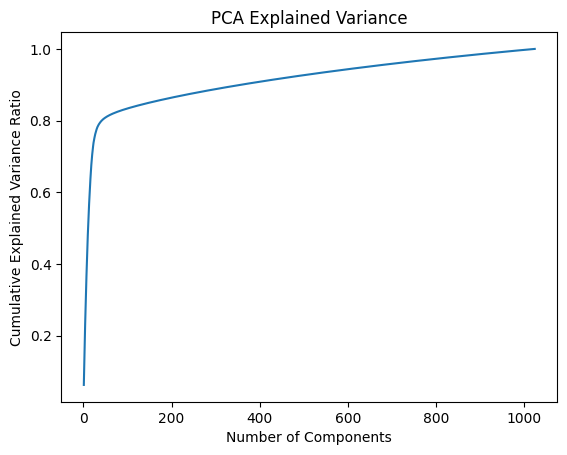

In [88]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize your features first
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Analyze explained variance ratio
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Plot explained variance
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('PCA Explained Variance')
plt.show()

In [89]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score

# Fit Lasso with different alpha values
alphas = [0.001, 0.002, 0.003, 0.005, 0.007, 0.01]
for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_scaled, y)
    
    # Count non-zero coefficients
    n_nonzero = np.sum(lasso.coef_ != 0)
    print(f"Alpha: {alpha}, Non-zero coefficients: {n_nonzero}")
    
    # Plot largest coefficients
    coef_importance = pd.DataFrame({
        'Feature': range(len(lasso.coef_)),
        'Coefficient': abs(lasso.coef_)
    }).sort_values('Coefficient', ascending=False)

/home/jrodriguez/miniconda3/envs/deep-k-correct/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.139e+00, tolerance: 3.631e+00
  model = cd_fast.enet_coordinate_descent(


Alpha: 0.001, Non-zero coefficients: 497
Alpha: 0.002, Non-zero coefficients: 325
Alpha: 0.003, Non-zero coefficients: 241
Alpha: 0.005, Non-zero coefficients: 153
Alpha: 0.007, Non-zero coefficients: 122
Alpha: 0.01, Non-zero coefficients: 91


Alpha Parameter: This is the regularization strength in Lasso regression.
- Larger alpha = stronger regularization
- Smaller alpha = weaker regularization

Lasso performs both regression and feature selection
- Even with very weak regularization (α=0.001), about half the features are dropped
- There's a smooth decrease in feature count as α increases
- Tere seems to be ~100 - 150 important features 

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# Create RFE with desired number of features
n_features_to_select = 100  # adjust as needed
rfe = RFE(estimator=LinearRegression(), n_features_to_select=n_features_to_select)
rfe = rfe.fit(X, y)

# Get selected features
selected_features = np.where(rfe.support_)[0]
print(f"Selected features: {selected_features}")

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=20)
rf.fit(X, y)

# Get feature importance
importance = pd.DataFrame({
    'Feature': range(X.shape[1]),
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

# Plot top N important features
plt.figure(figsize=(10, 6))
plt.bar(range(20), importance['Importance'][:20])
plt.title('Top 20 Most Important Features')
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.show()

In [14]:
from sklearn.feature_selection import mutual_info_regression

# Calculate mutual information between each feature and target
mi_scores = mutual_info_regression(X, y)

# Plot scores
plt.figure(figsize=(10, 6))
plt.bar(range(len(mi_scores)), mi_scores)
plt.title('Mutual Information Scores')
plt.xlabel('Feature Index')
plt.ylabel('Mutual Information')
plt.show()

NameError: name 'X' is not defined

In [ ]:
# Calculate correlation matrix
corr_matrix = pd.DataFrame(X).corr()

# Find highly correlated features
threshold = 0.9  # adjust as needed
high_corr = np.where(np.abs(corr_matrix) > threshold)
high_corr = [(i,j) for i, j in zip(*high_corr) if i < j]  # upper triangle only

print("Highly correlated feature pairs:")
for i, j in high_corr:
    print(f"Features {i} and {j}: {corr_matrix.iloc[i,j]:.3f}")